In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import gaussian_kde

In [3]:
from matplotlib import rcParams

In [4]:
import matplotlib.pylab as pylab
params = {'xtick.labelsize' : 'x-large', 'xtick.major.size':6}
pylab.rcParams.update(params)


In [5]:
std = 0.4

In [6]:
# x = np.linspace(-1.5, 1.5, 1000)

In [7]:
# # Create normal distribtution of standard deviation 0.2 (mean standard deviation)
# dist1 = np.random.normal(0, std, 100000)

# # Get the gaussian kernal density estimate
# kde1 = gaussian_kde(dist1)(x)

# # Normal by total of values so area is one. 
# kde1 = kde1 / np.sum(kde1)

In [8]:
# # Create normal distribtution of standard deviation 0.2 (mean standard deviation)

# dist2 = np.random.normal(0.5, std, 100000)

# # Get the gaussian kernal density estimate
# kde2 = gaussian_kde(dist2)(x)

# # Normal by total of values so area is one. 
# kde2 = kde2 / np.sum(kde2)

In [9]:
def gaussian(x, mean, std):
    return np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))

In [10]:
x2 = np.linspace(-1.5, 1.5, 100000)

In [11]:
std = 0.2

In [12]:
kde1 = gaussian(x2, 0, std)
kde2 = gaussian(x2, 0.5, std)

In [13]:
overlap = np.nanmin(np.array([kde1, kde2]).transpose(), axis=1)

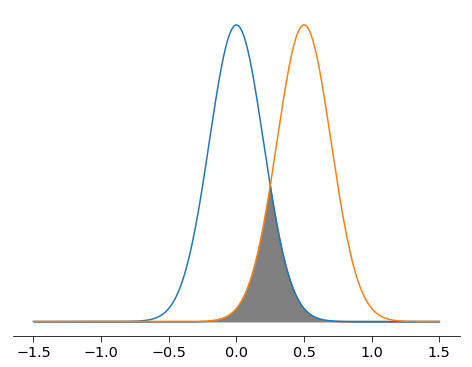

In [14]:
fig,ax = plt.subplots(figsize=(8, 6))
ax.plot(x2,kde1)
ax.plot(x2,kde2)
ax.fill_between(x2, [0] * len(overlap), overlap, color='grey')

# Remove all spoines but x-axis
[ax.spines[spine].set_visible(False) for spine in ['top', 'left', 'right']]

ax.set_yticks([]);

In [15]:
x2 = np.linspace(-10, 10, 100000)

In [16]:
out = gaussian(x2, 1, 1)

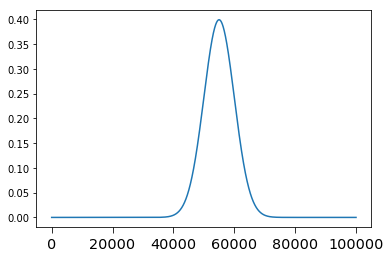

In [17]:
plt.plot(out)

# Distribution Animation

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import climate_utils
import plotting_utils
import stats
import time_of_emergence_plots
import time_of_emrgence_calc as toe
import toe_constants as toe_const

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /jobfs/116341073.gadi-pbs/matplotlib-8rh92j71 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:

import matplotlib.pylab as pylab
params = {'axes.labelsize' : 'xx-large', 'legend.fontsize': 'xx-large', 
          'xtick.labelsize': 'xx-large', 'ytick.labelsize': 'xx-large'}
            
pylab.rcParams.update(params)

In [3]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

In [4]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Complete_TAVG_LatLong1.nc',
 'best_mask_old.zarr',
 'best_mask.zarr',
 'Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [5]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()
best_ds = best_ds.compute()

In [6]:
best_ds_smean = climate_utils.weighted_lat_lon_mean(best_ds)

In [7]:
best_ds_smean = best_ds_smean.compute()

In [8]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds_smean.where(best_ds_smean.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... -0.2842 -0.193 -0.1842 -0.3879 -0.2289
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [9]:
base_period_ds_average = base_period_ds.mean(dim='time')
base_period_ds_average

<xarray.DataArray 'temperature' ()>
-0.2854

In [10]:
# Resetting the anomlies to 1850
best_ds_smean = best_ds_smean - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

In [55]:
bins = np.arange(-3, 3, 0.15)

In [56]:
hist, bin_edges = np.histogram(best_ds_smean.isel(time=slice(1, 51)).values)

In [57]:
hist = hist/sum(hist)

(-3.0, 2.849999999999996)

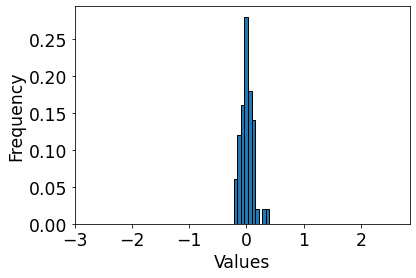

In [60]:
fig , ax = plt.subplots()
ax.hist(bin_edges[:-1], bin_edges, weights=hist, edgecolor='black')

# Add title and labels
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_xlim(np.take(bins, [0, -1]))

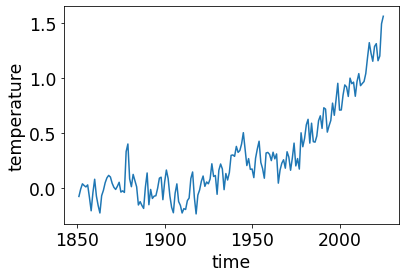

In [72]:
best_ds_smean.plot()

In [77]:
bins

array([-3.00000000e+00, -2.85000000e+00, -2.70000000e+00, -2.55000000e+00,
       -2.40000000e+00, -2.25000000e+00, -2.10000000e+00, -1.95000000e+00,
       -1.80000000e+00, -1.65000000e+00, -1.50000000e+00, -1.35000000e+00,
       -1.20000000e+00, -1.05000000e+00, -9.00000000e-01, -7.50000000e-01,
       -6.00000000e-01, -4.50000000e-01, -3.00000000e-01, -1.50000000e-01,
       -1.77635684e-15,  1.50000000e-01,  3.00000000e-01,  4.50000000e-01,
        6.00000000e-01,  7.50000000e-01,  9.00000000e-01,  1.05000000e+00,
        1.20000000e+00,  1.35000000e+00,  1.50000000e+00,  1.65000000e+00,
        1.80000000e+00,  1.95000000e+00,  2.10000000e+00,  2.25000000e+00,
        2.40000000e+00,  2.55000000e+00,  2.70000000e+00,  2.85000000e+00])

In [80]:
hist, bin_edges = np.histogram(best_ds_smean.isel(time=slice(i, i+50)).values, bins=bins)

<BarContainer object of 39 artists>

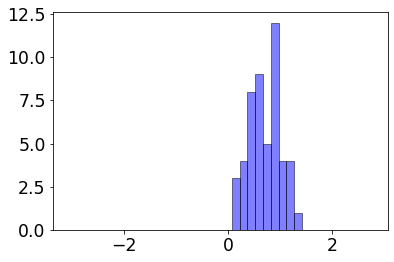

In [84]:
plt.bar(bin_edges[:-1], hist,width=0.15, edgecolor='black', color='blue', alpha=0.5)# weights=hist, edgecolor='black', color='blue', alpha=0.5)

In [87]:
from scipy.stats import gaussian_kde

In [88]:
x = np.arange(-3, 3, 200)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 

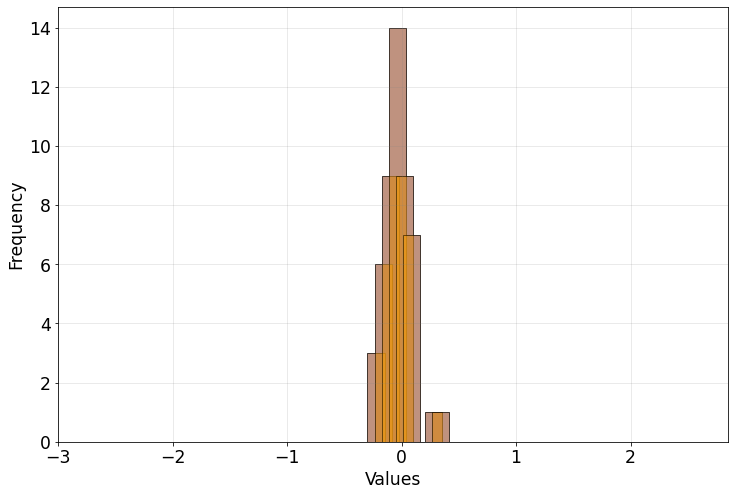

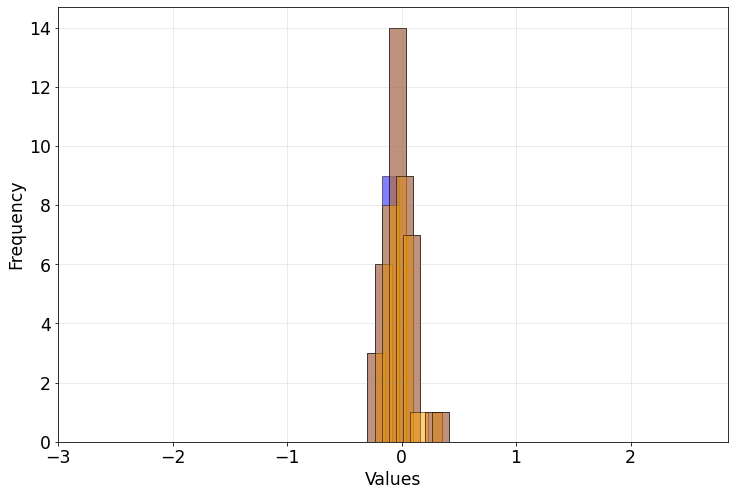

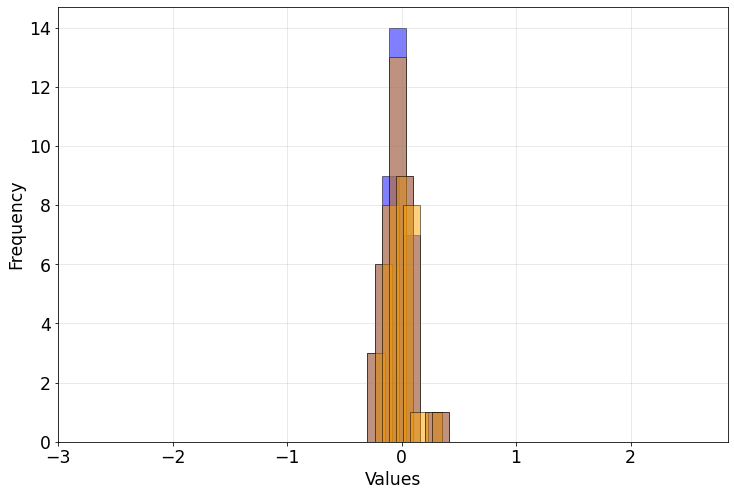

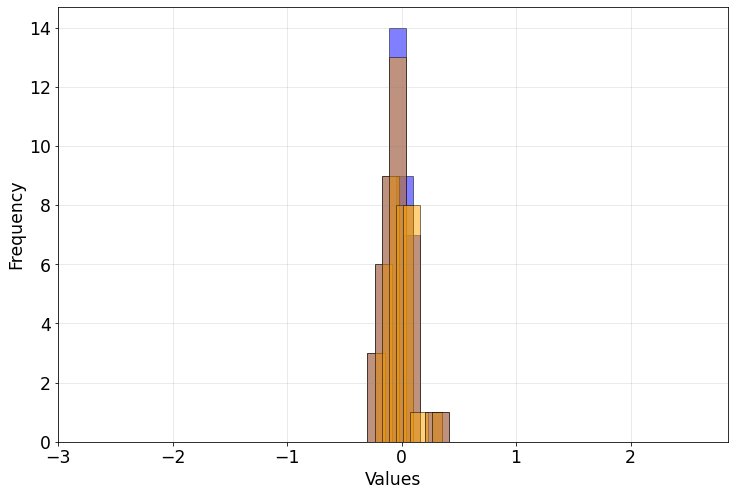

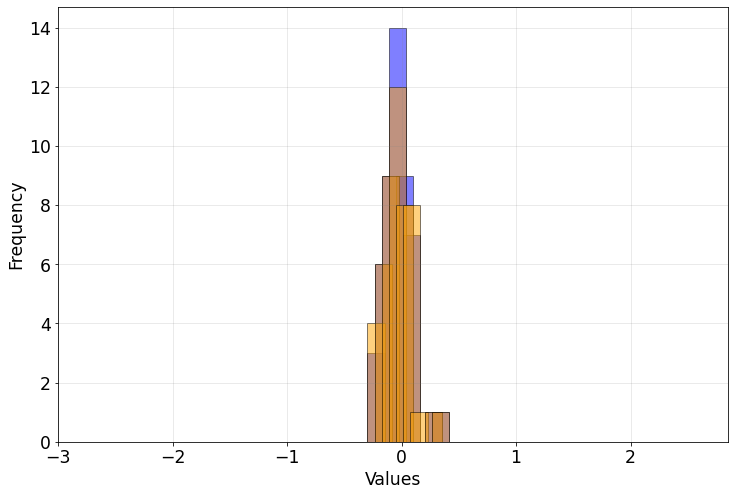

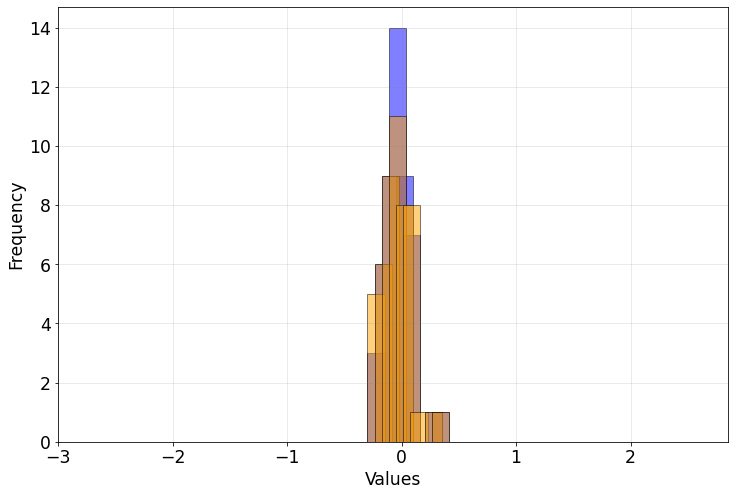

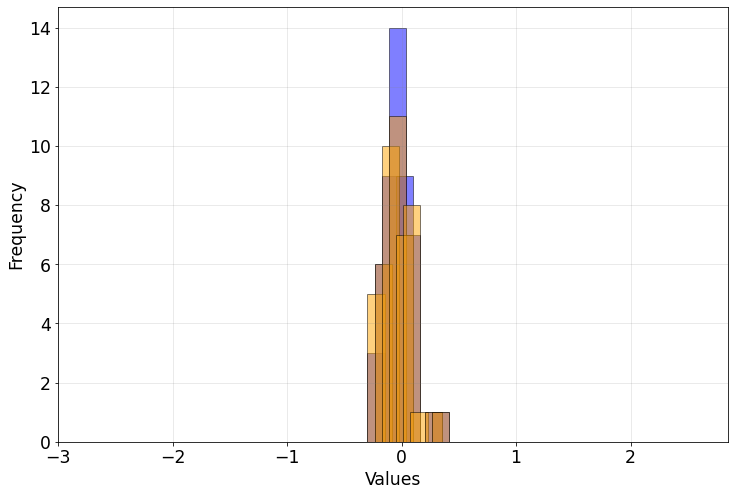

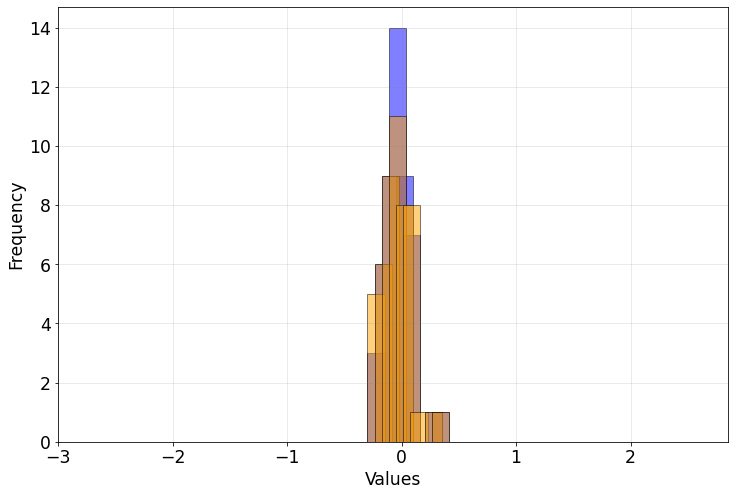

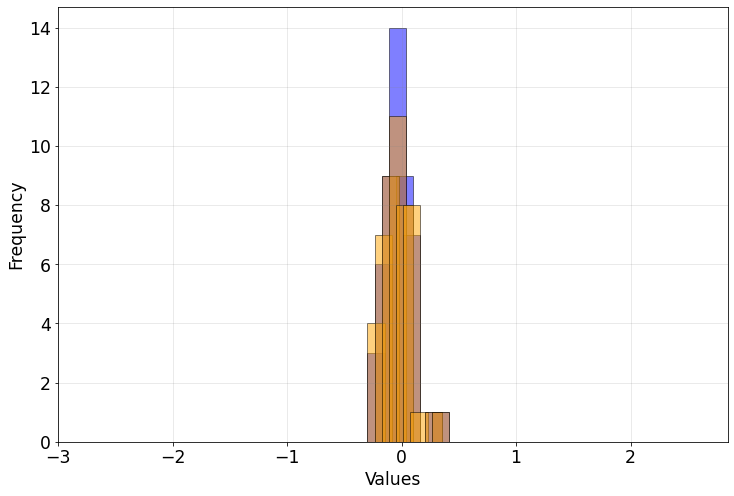

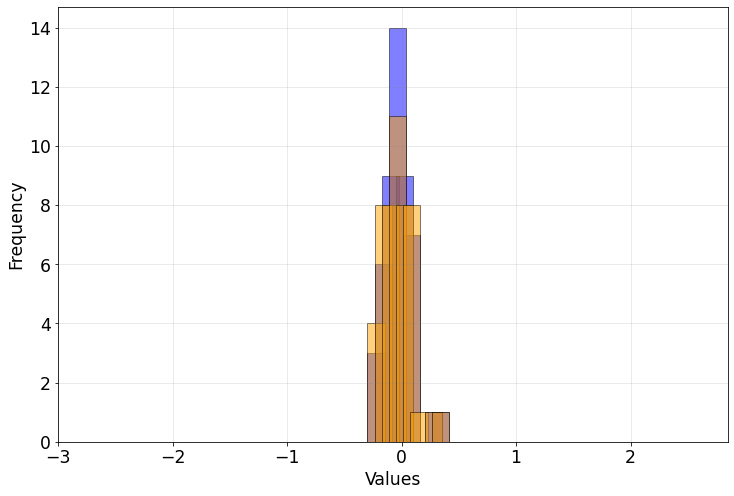

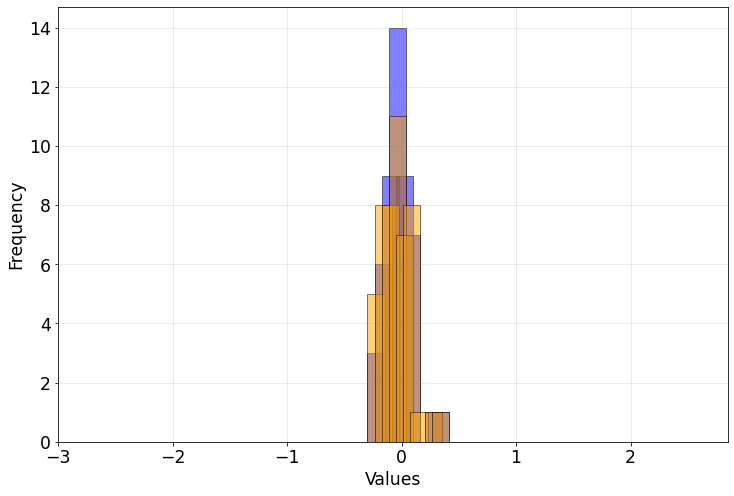

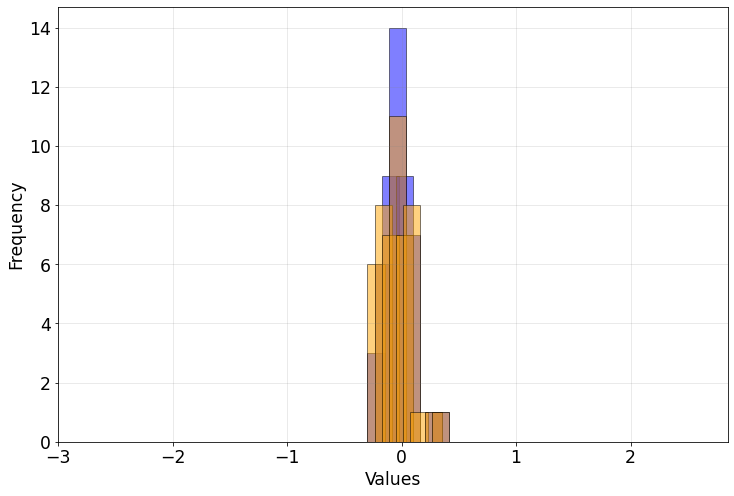

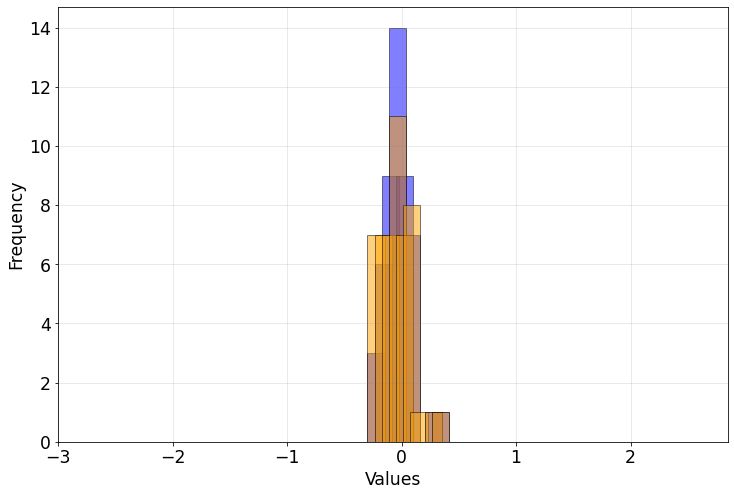

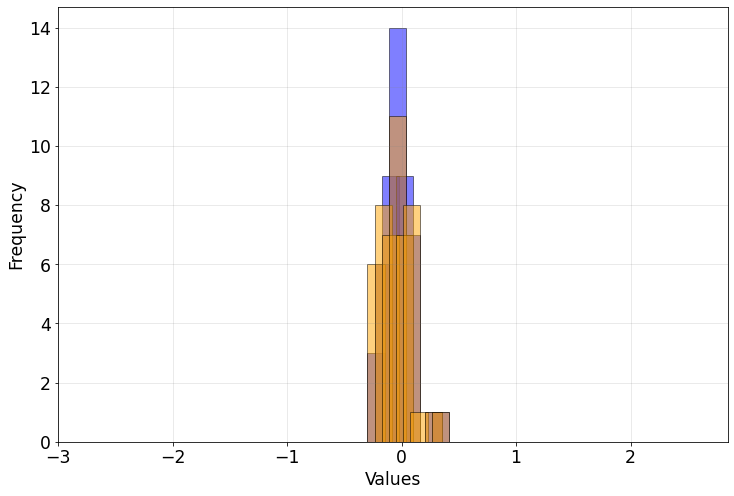

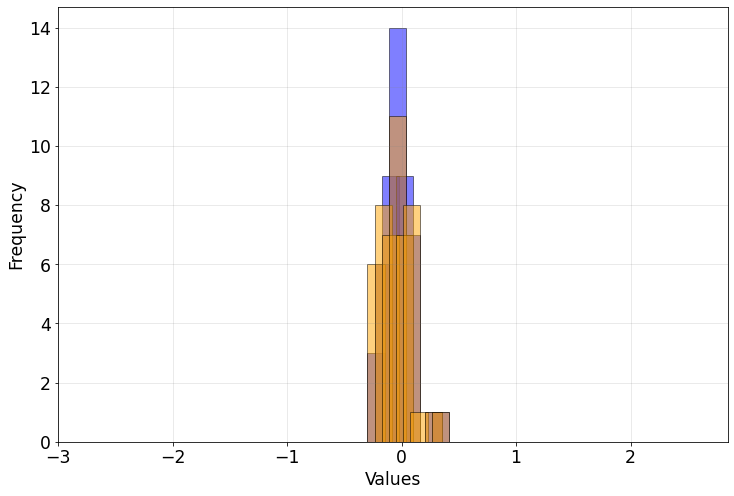

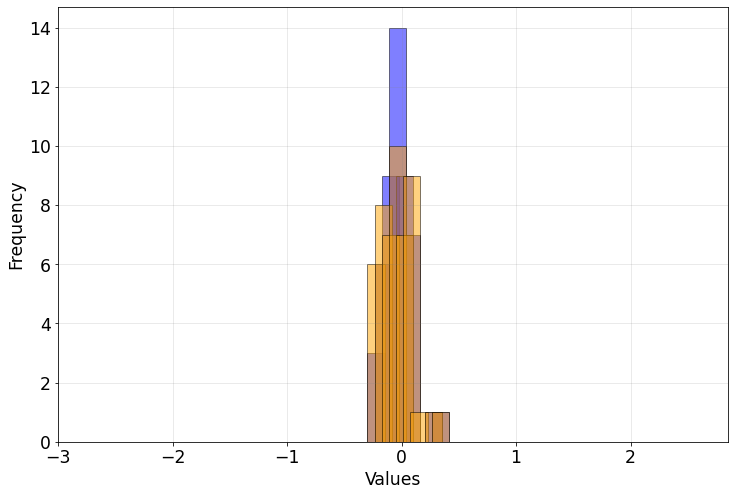

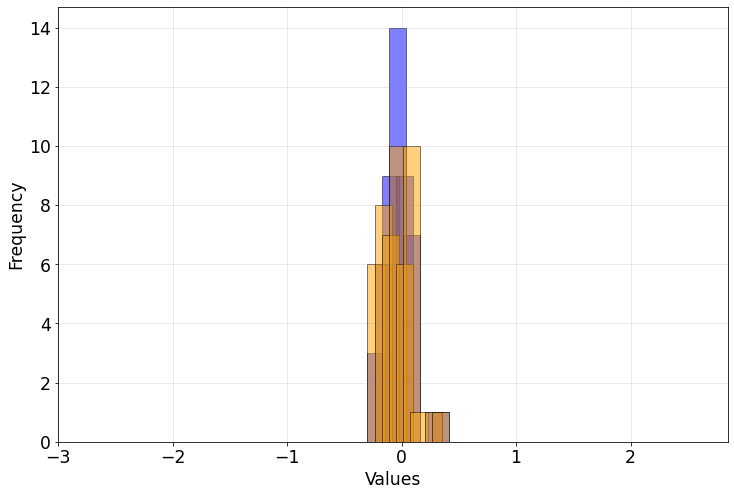

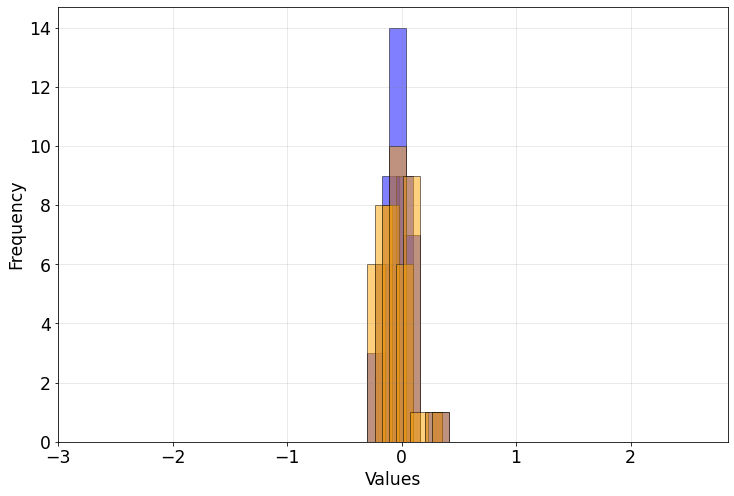

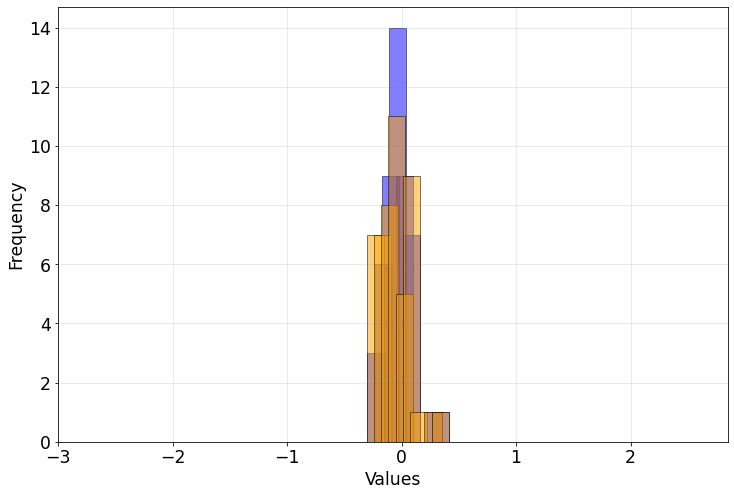

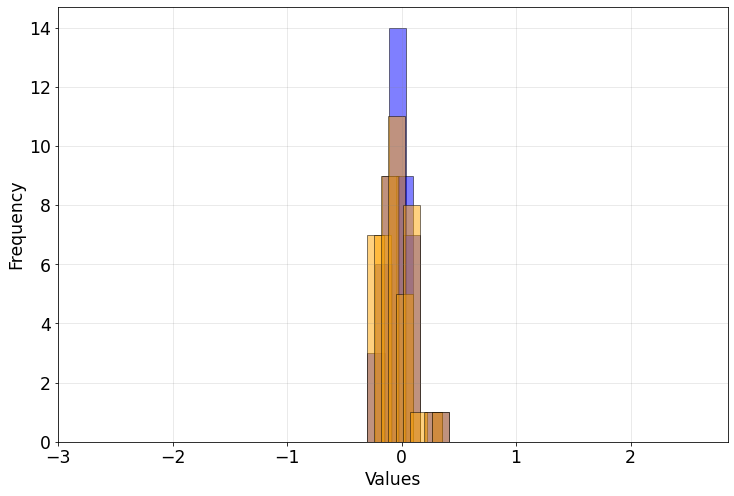

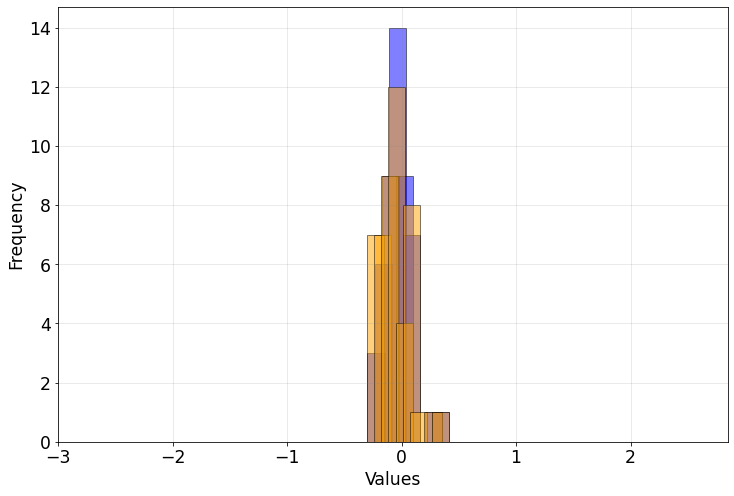

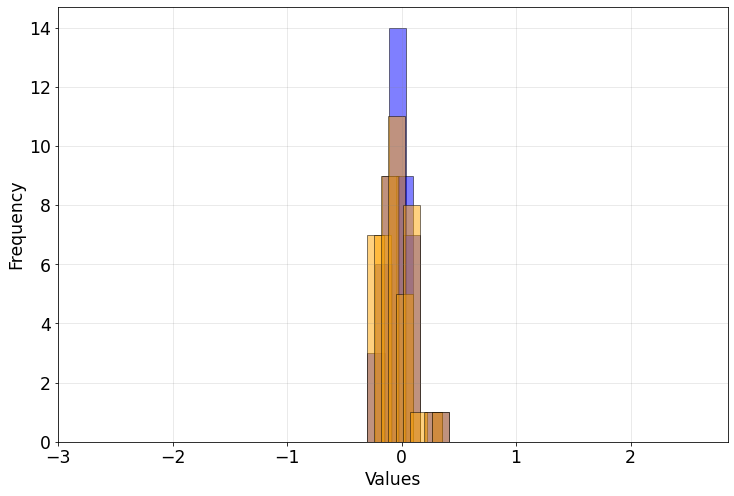

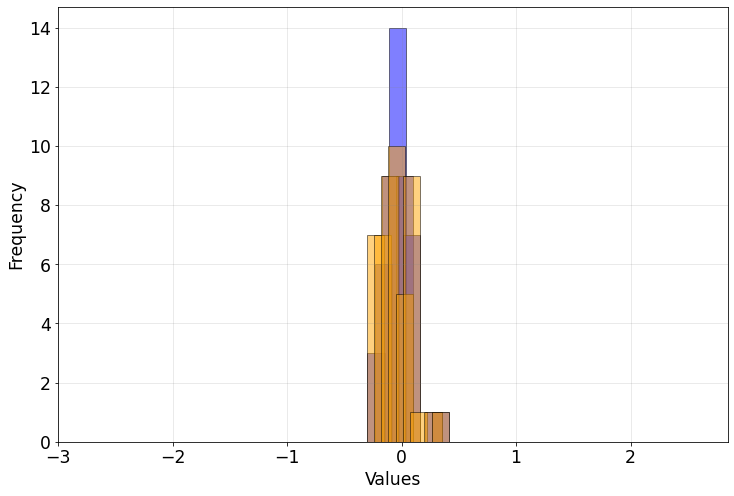

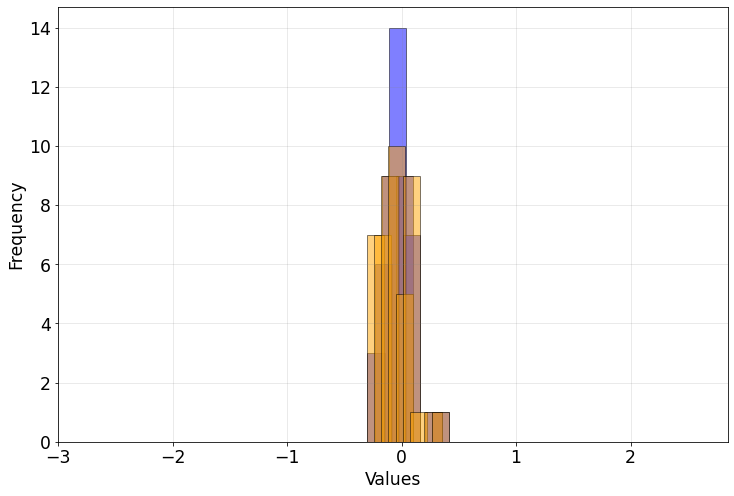

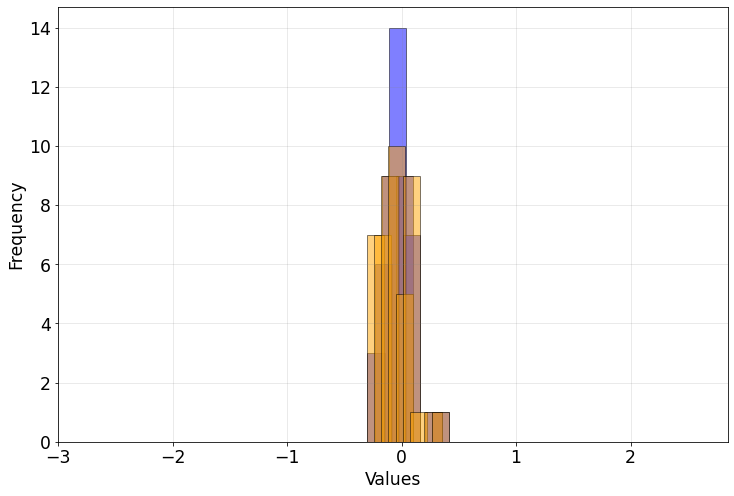

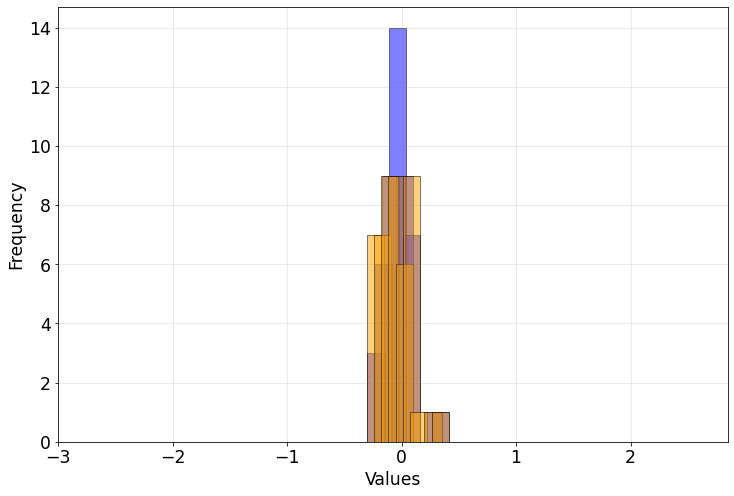

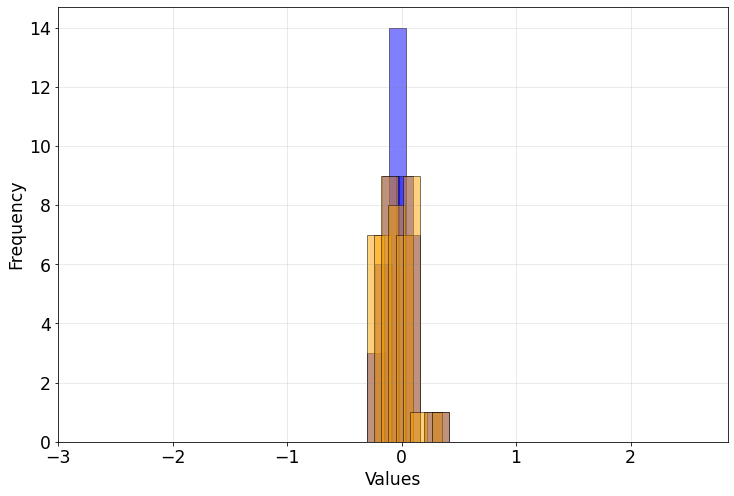

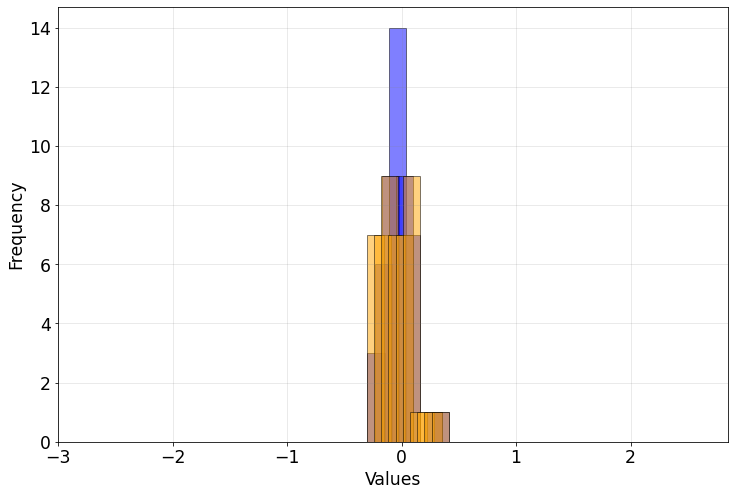

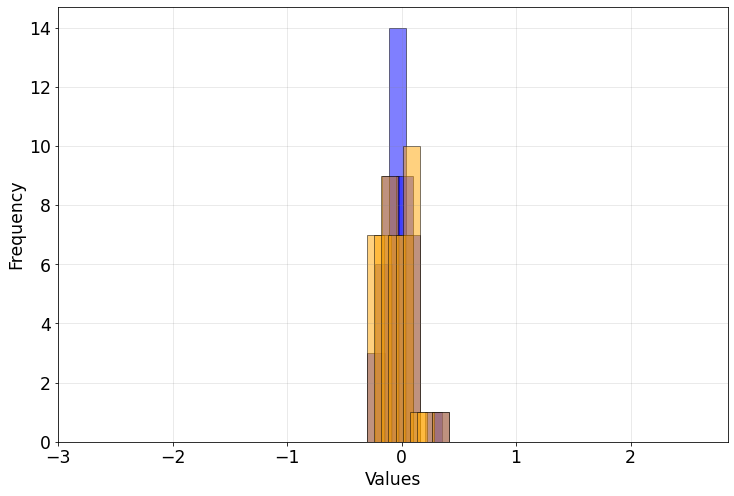

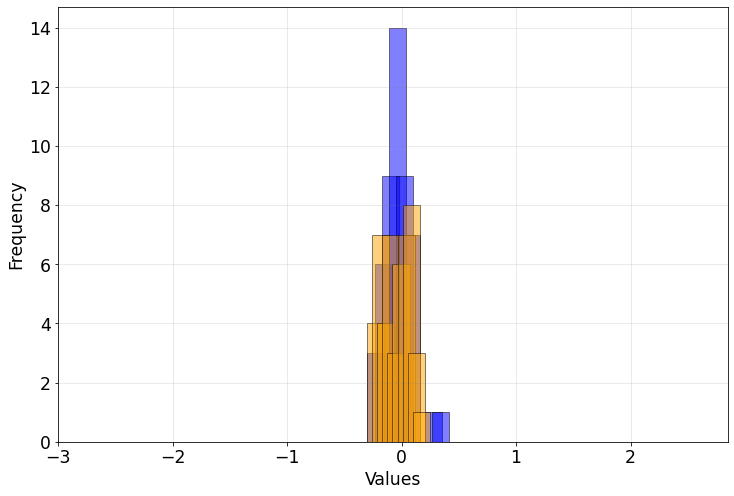

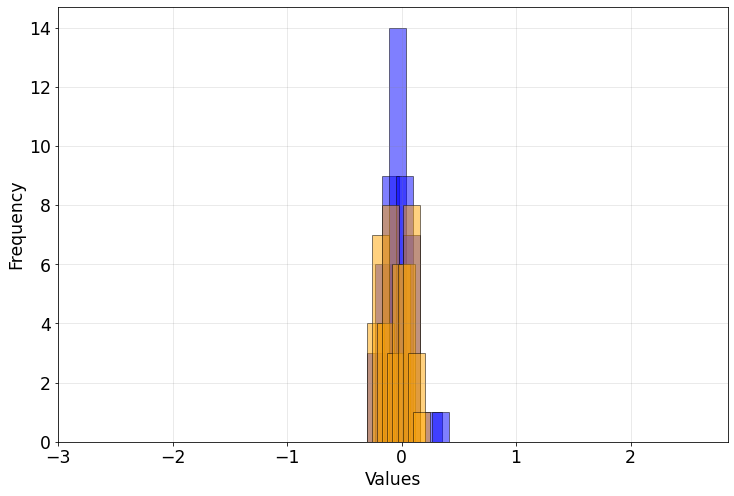

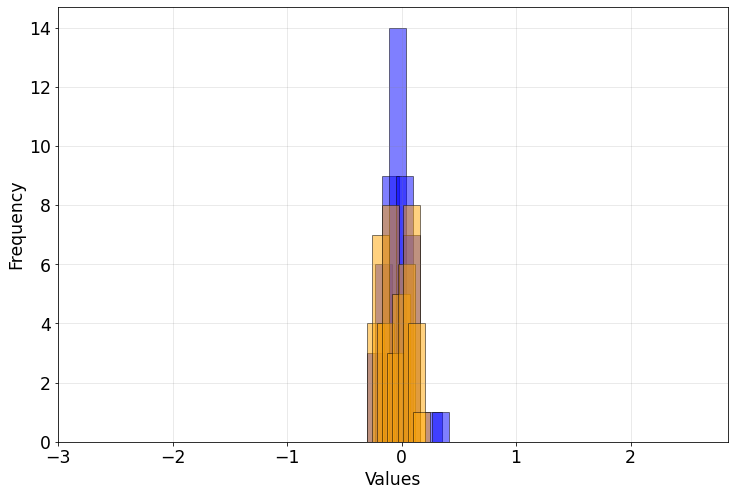

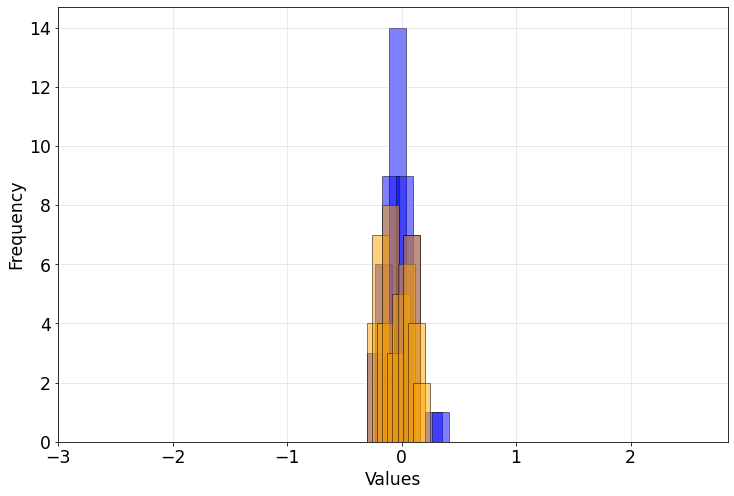

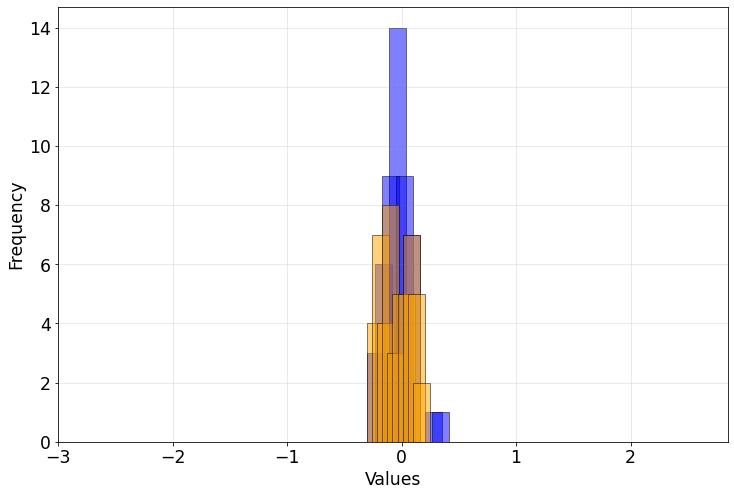

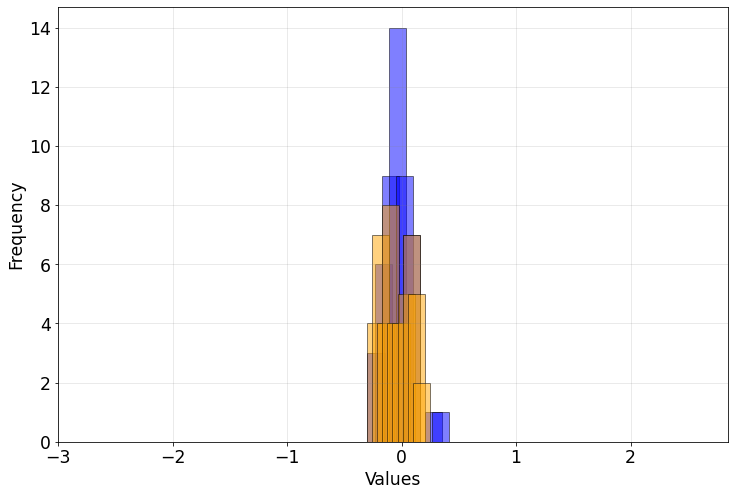

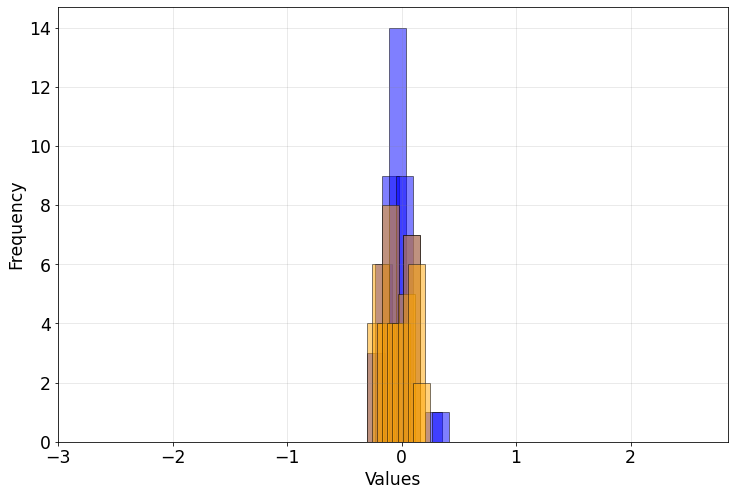

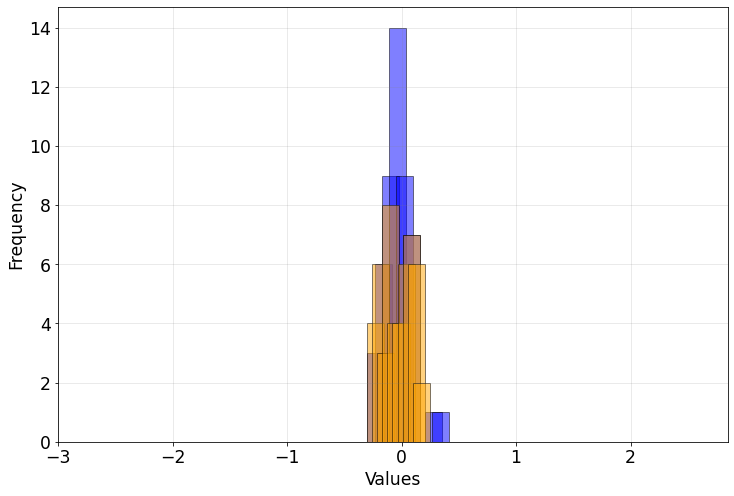

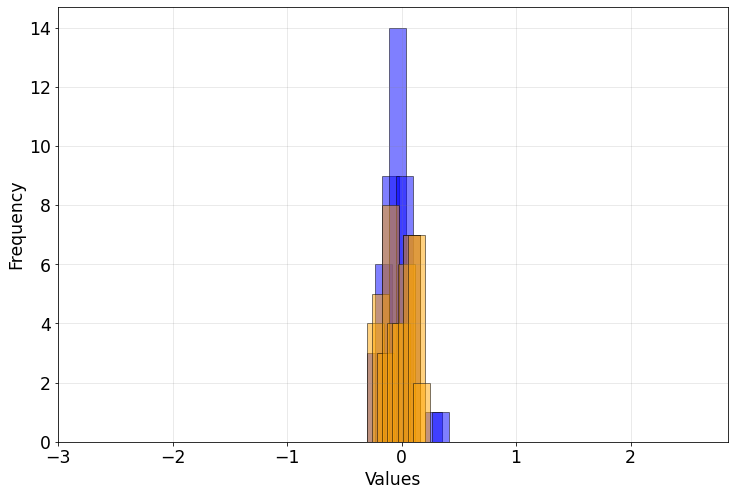

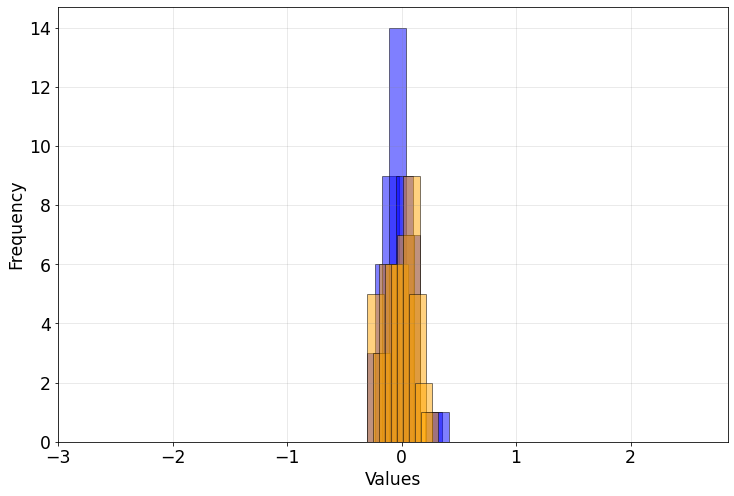

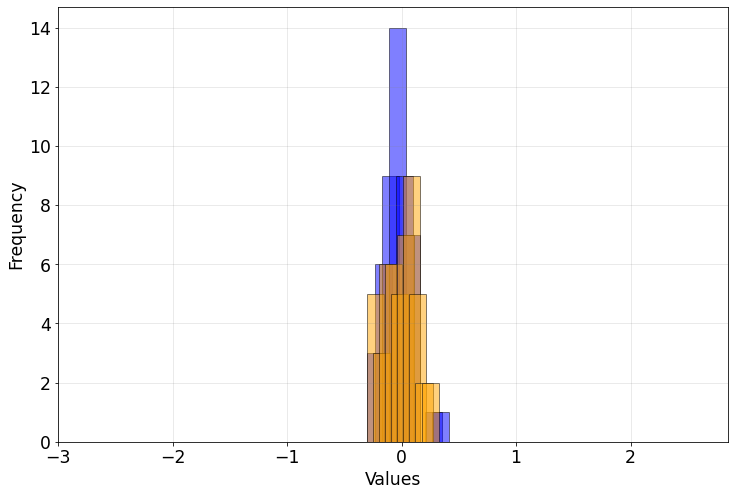

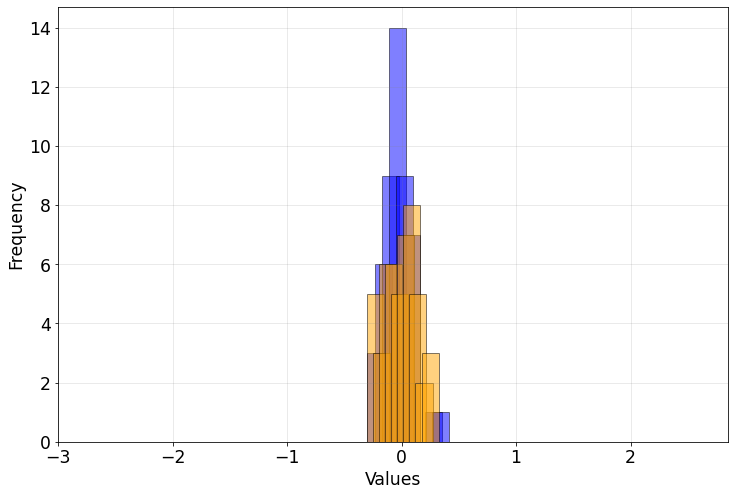

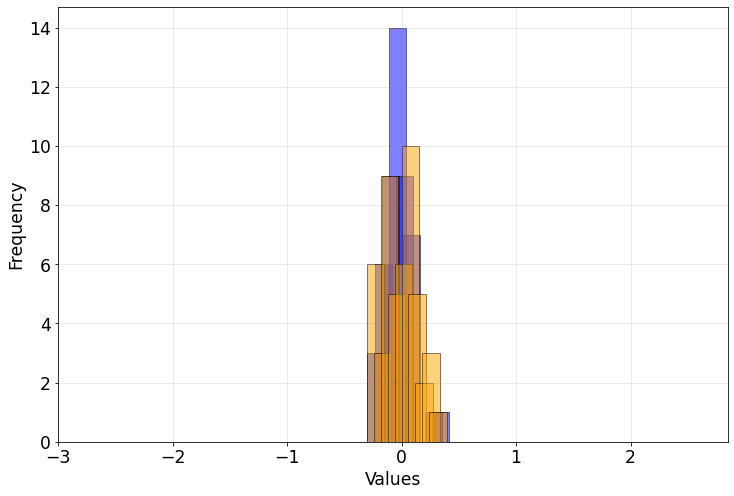

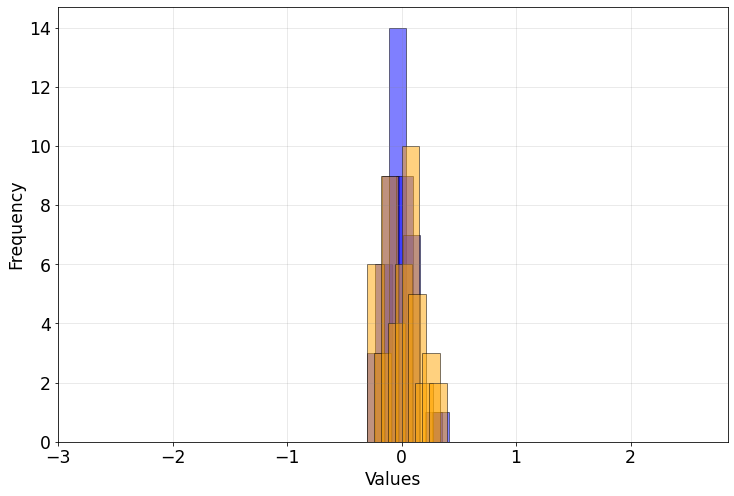

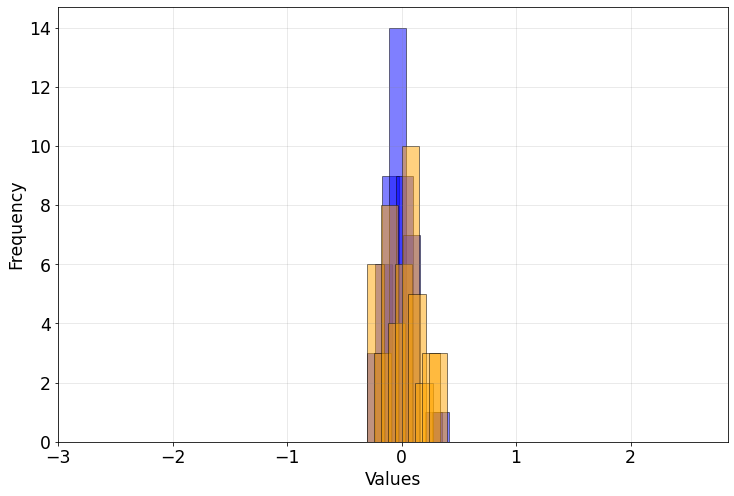

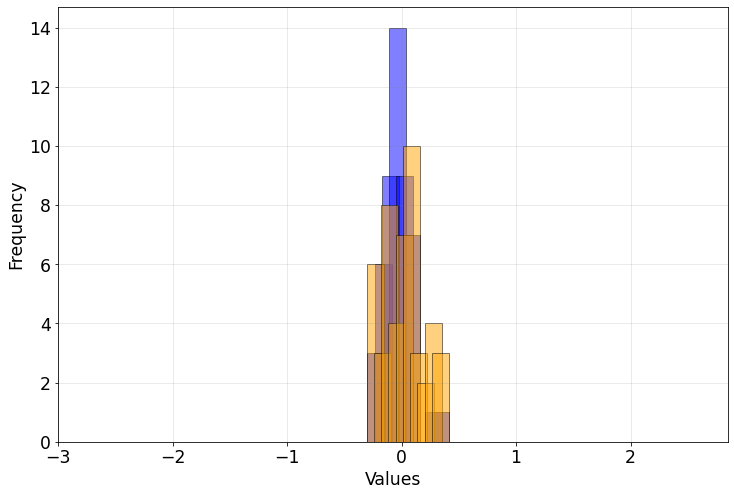

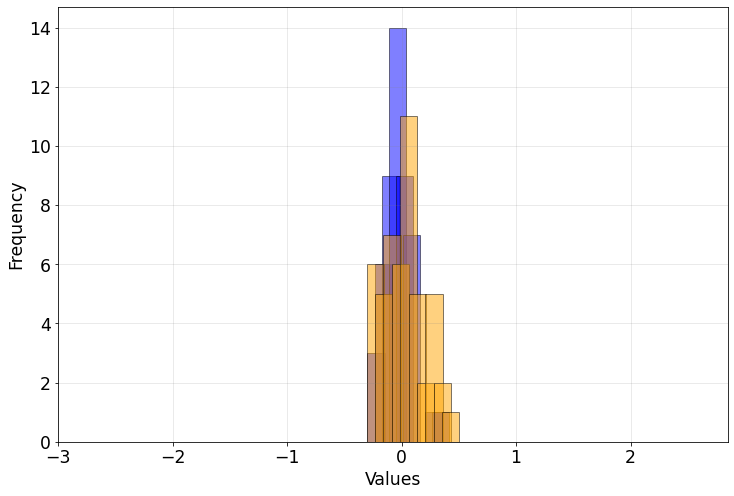

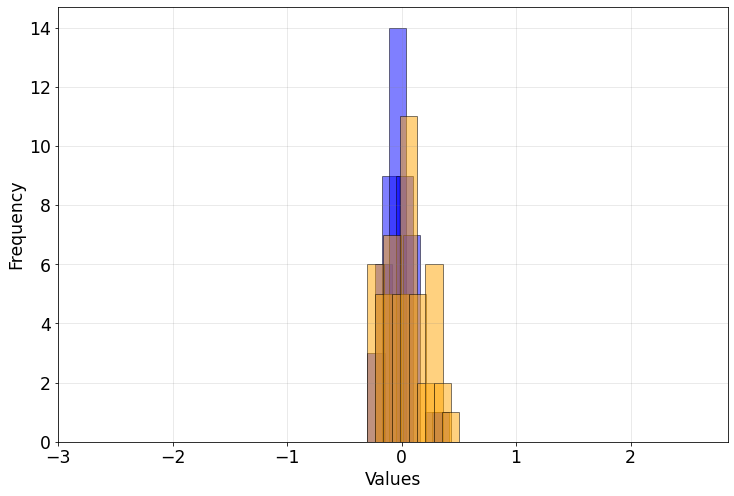

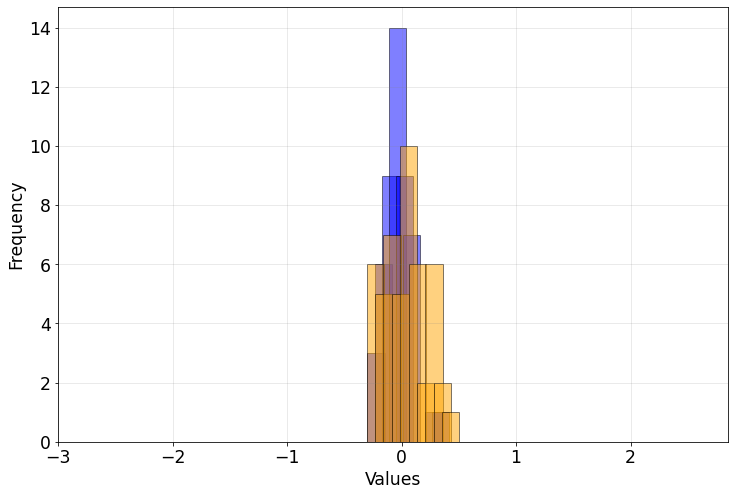

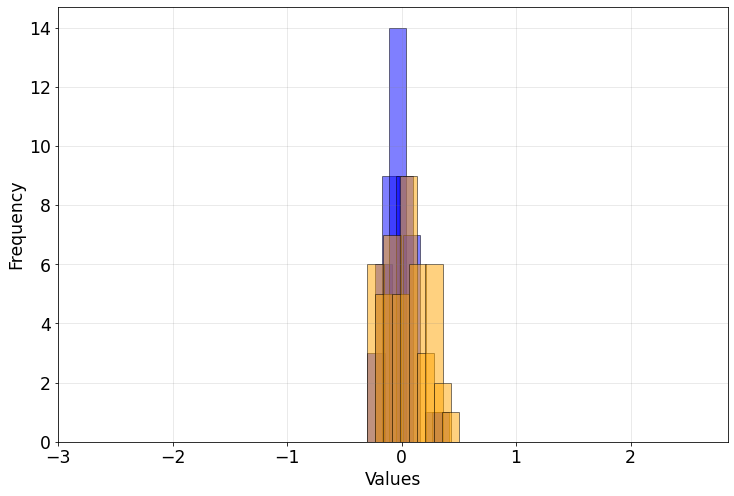

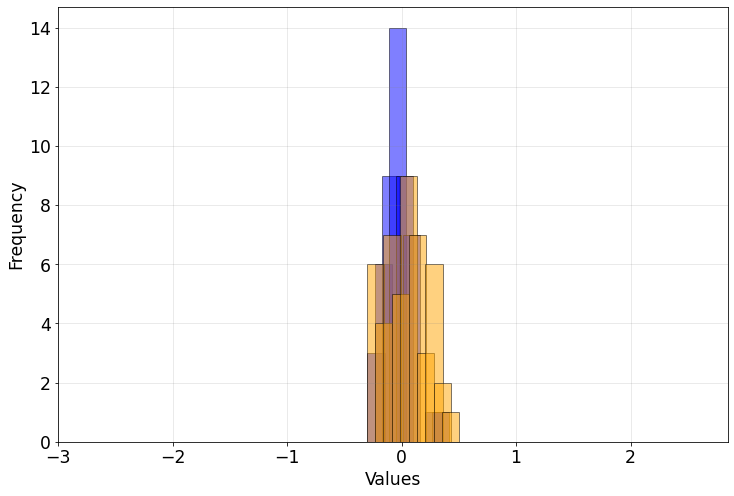

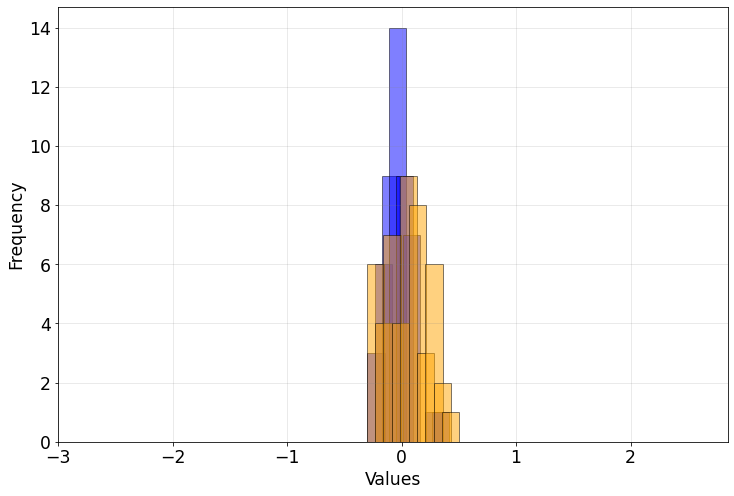

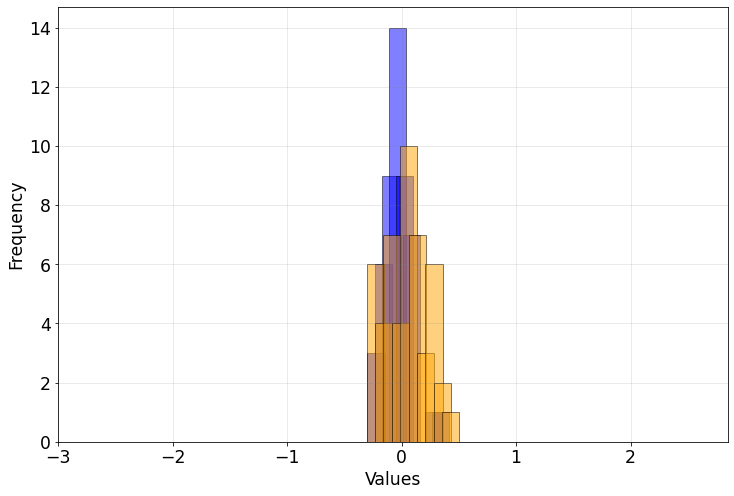

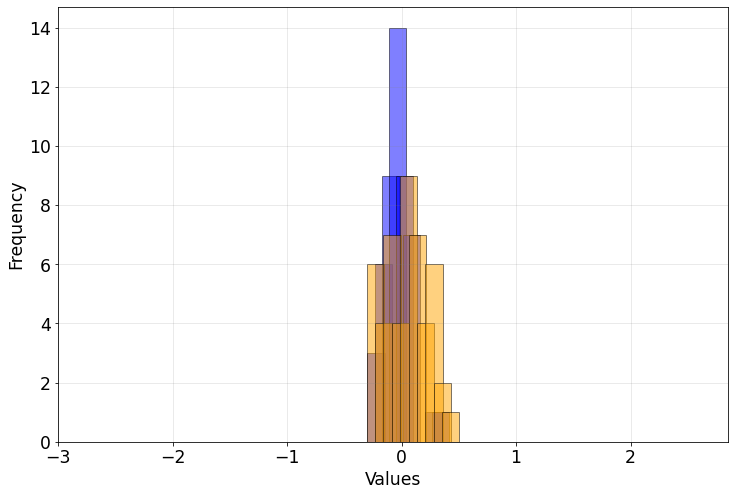

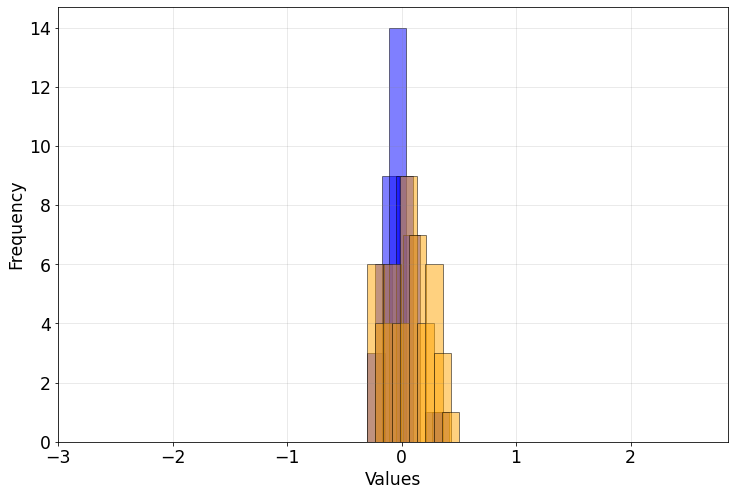

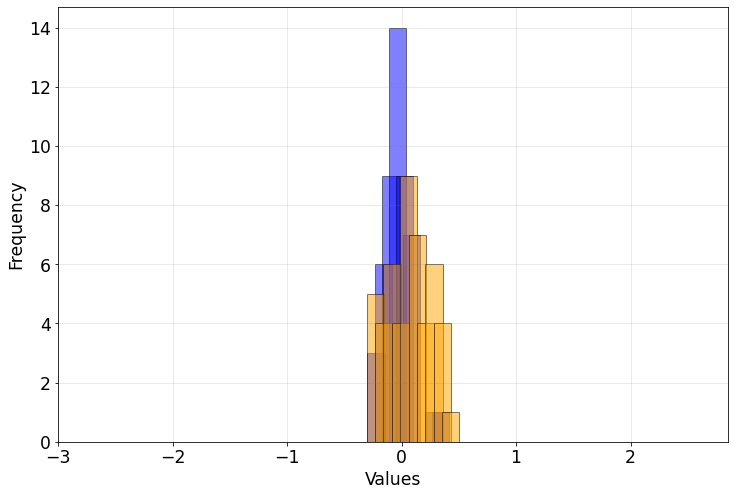

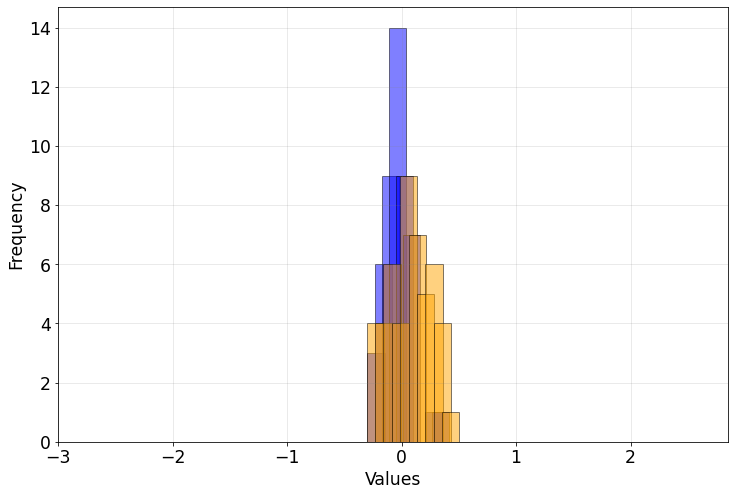

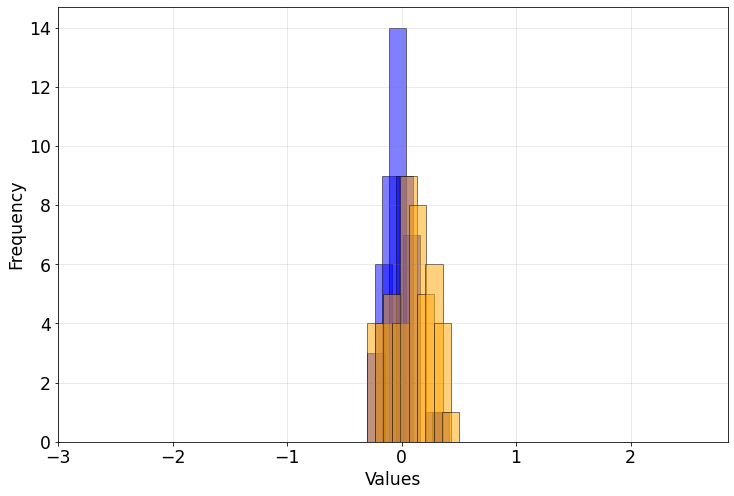

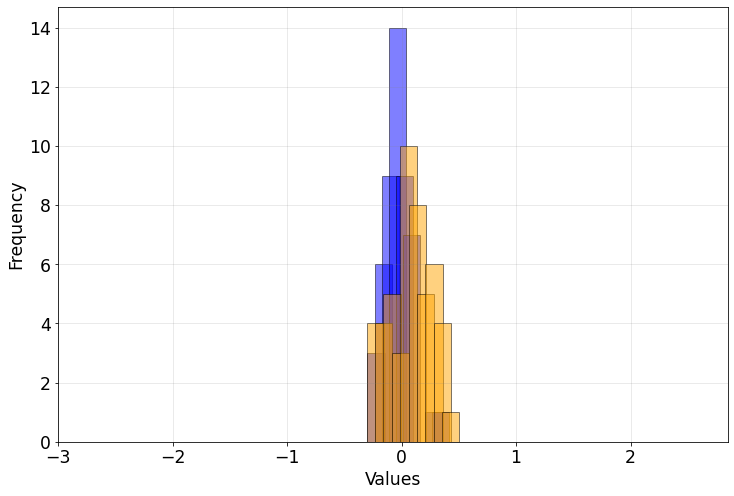

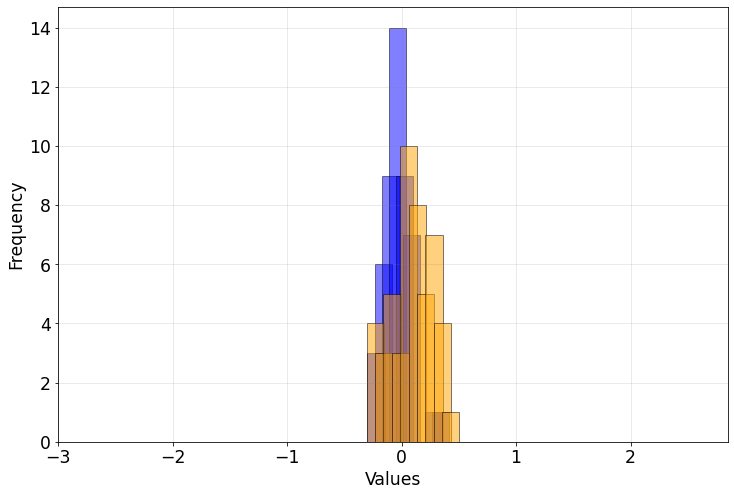

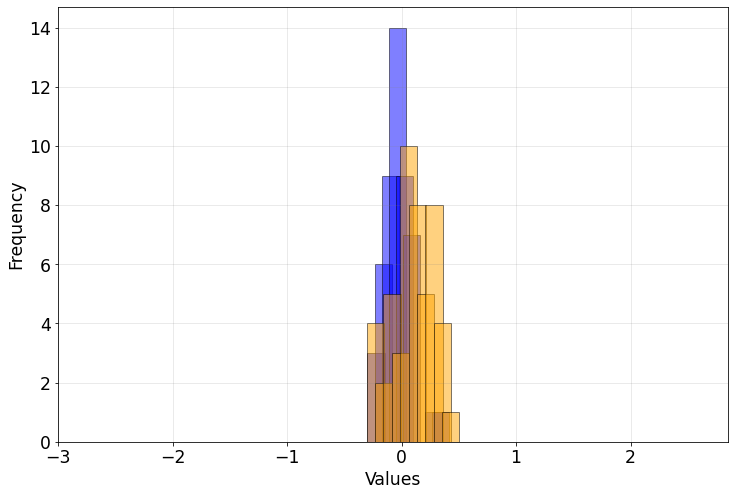

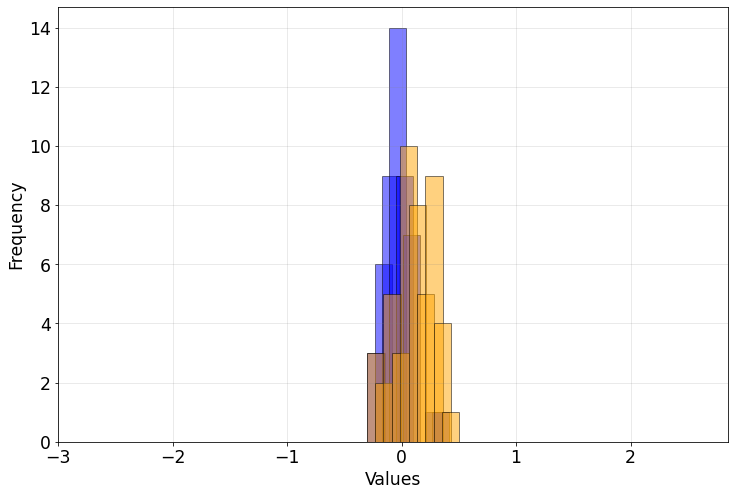

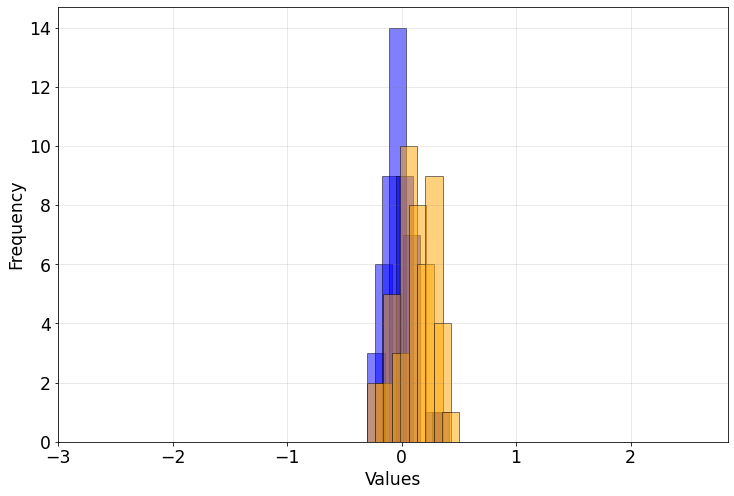

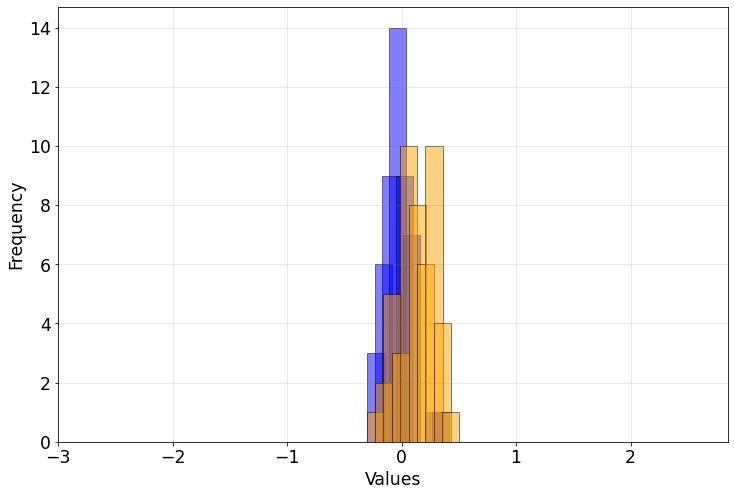

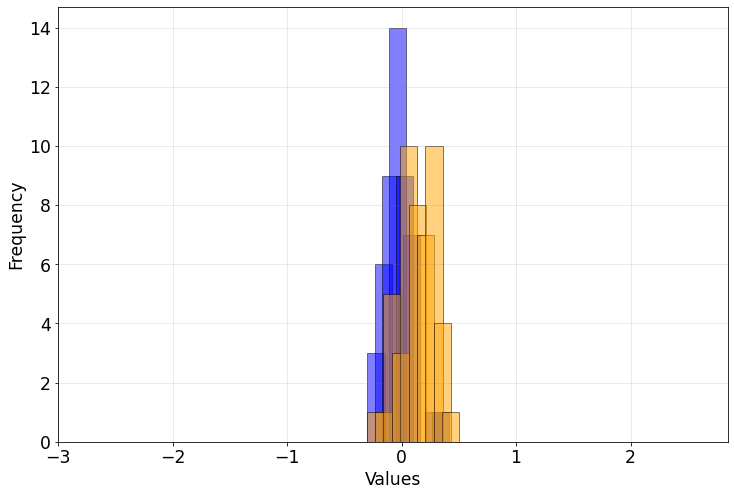

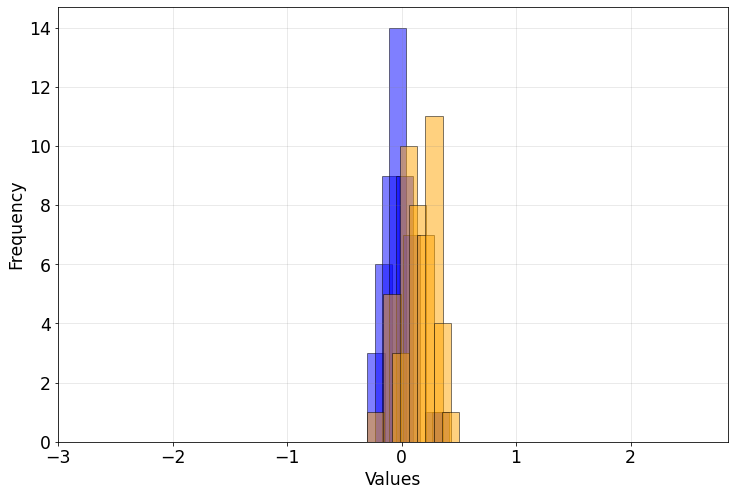

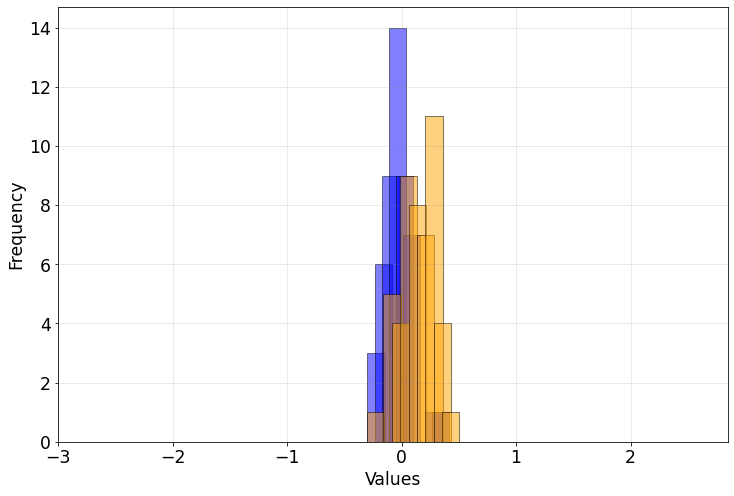

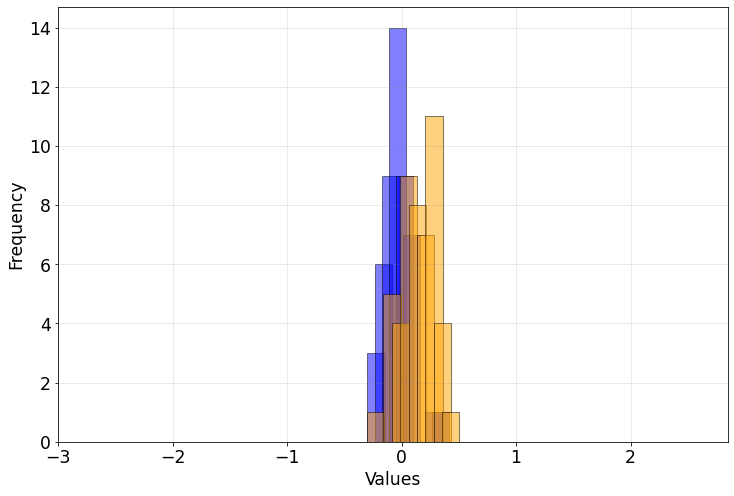

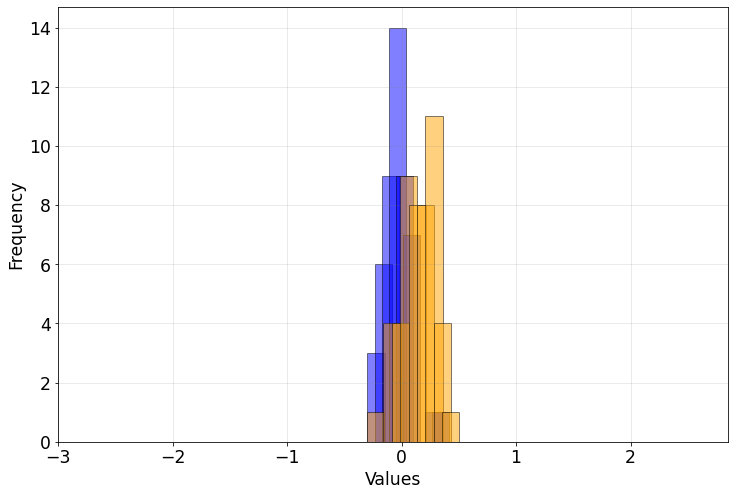

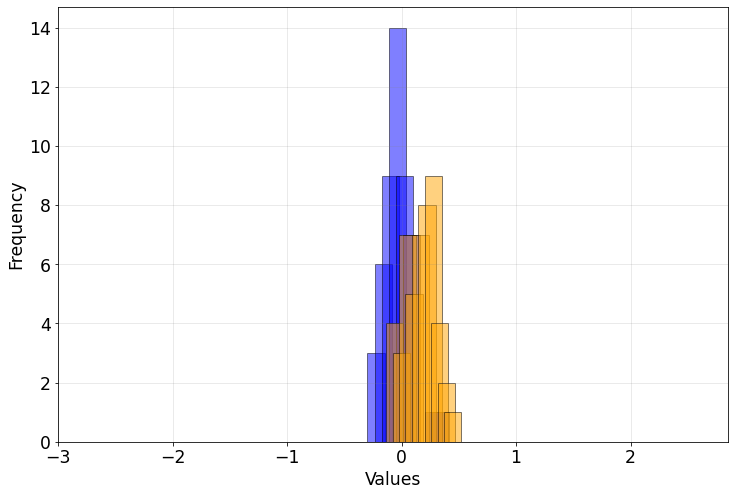

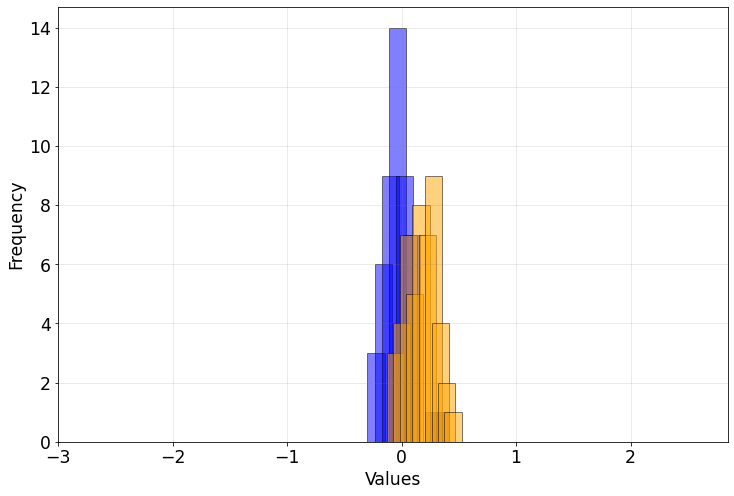

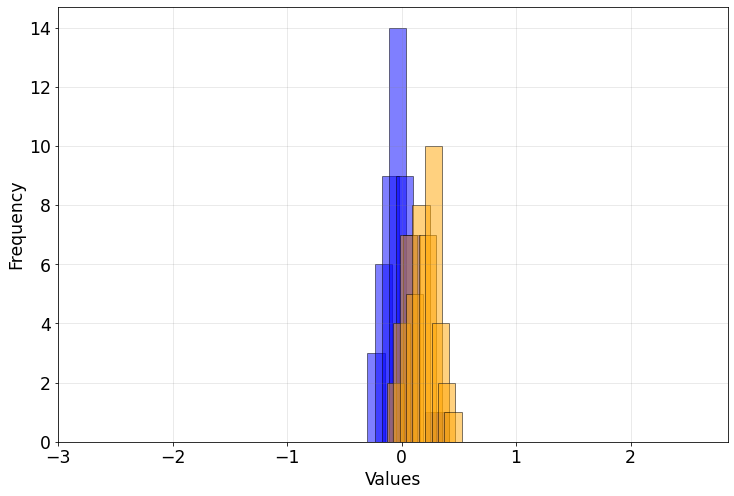

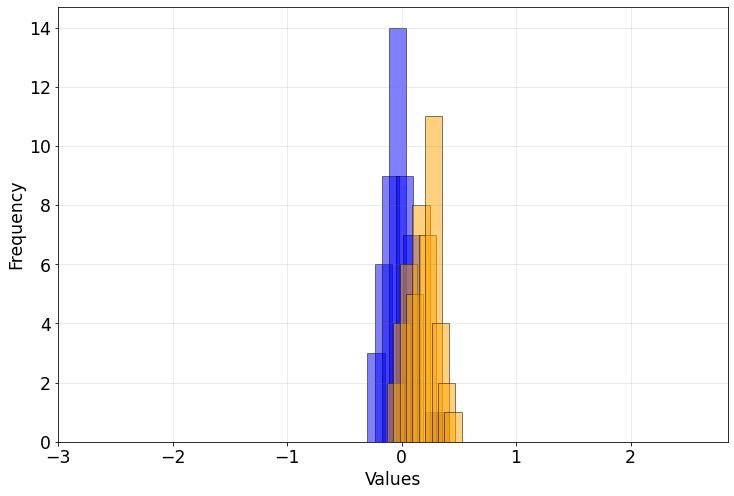

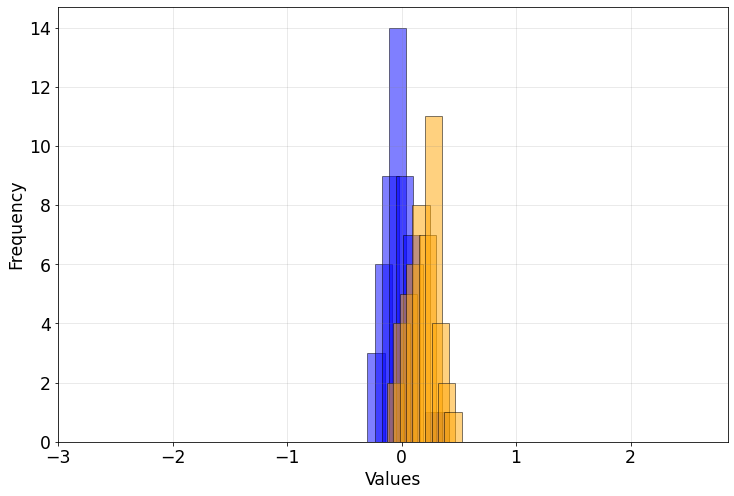

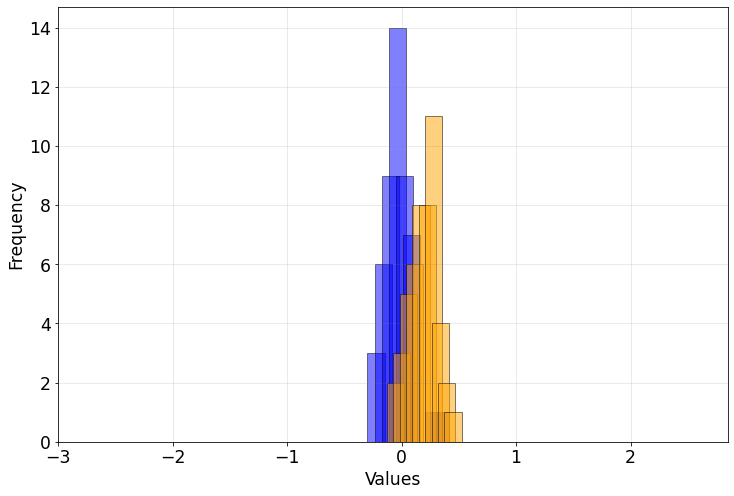

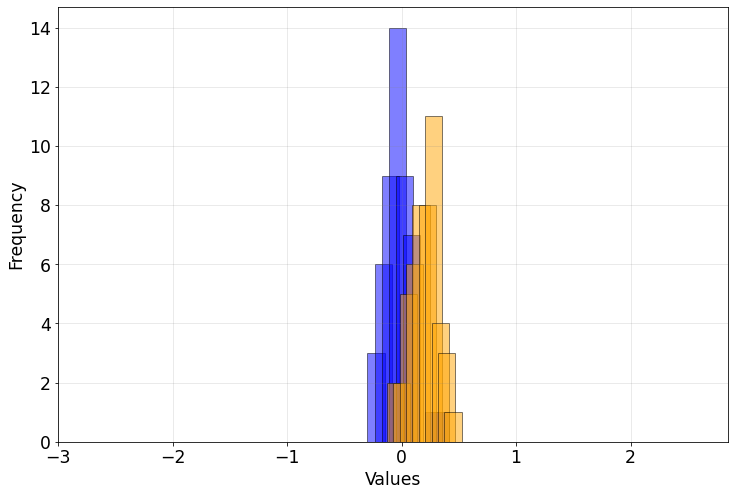

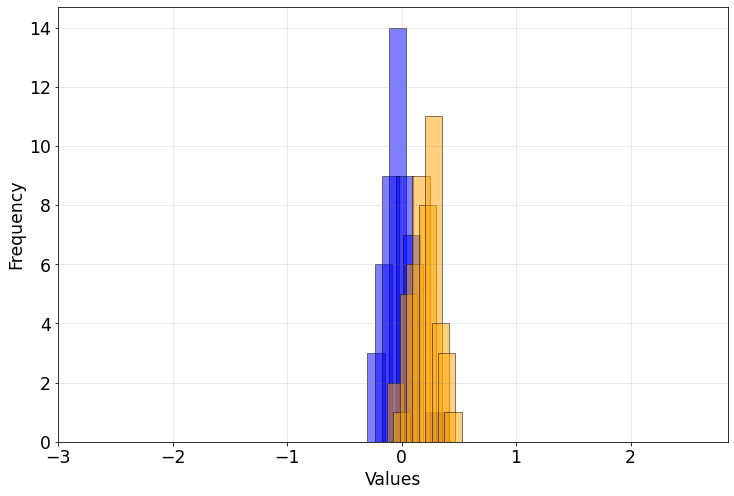

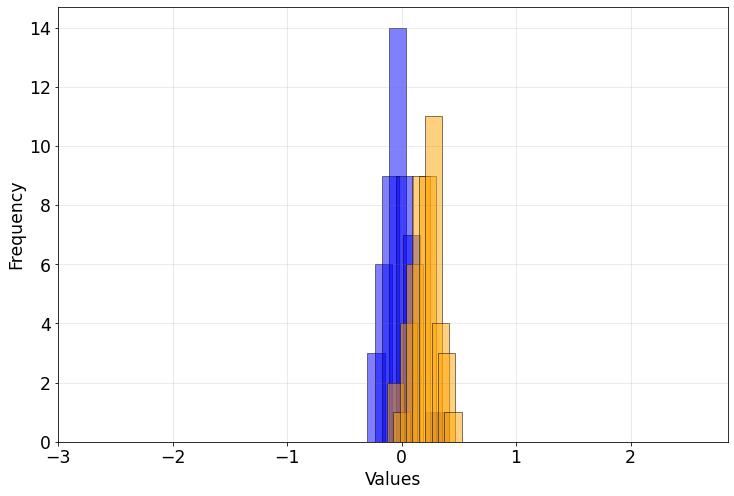

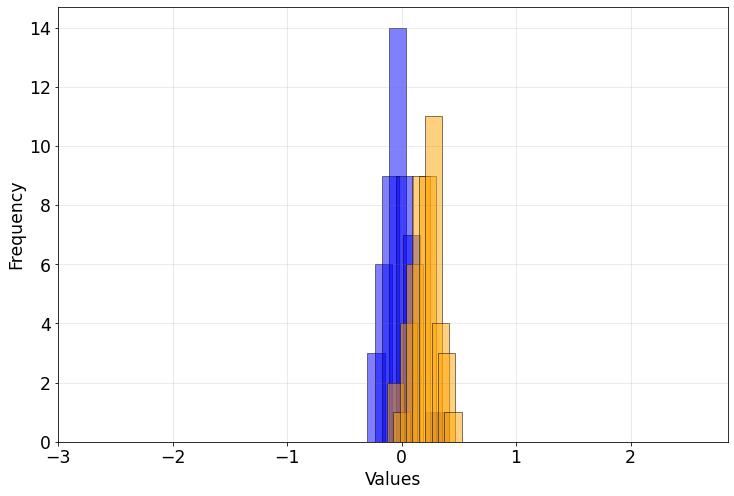

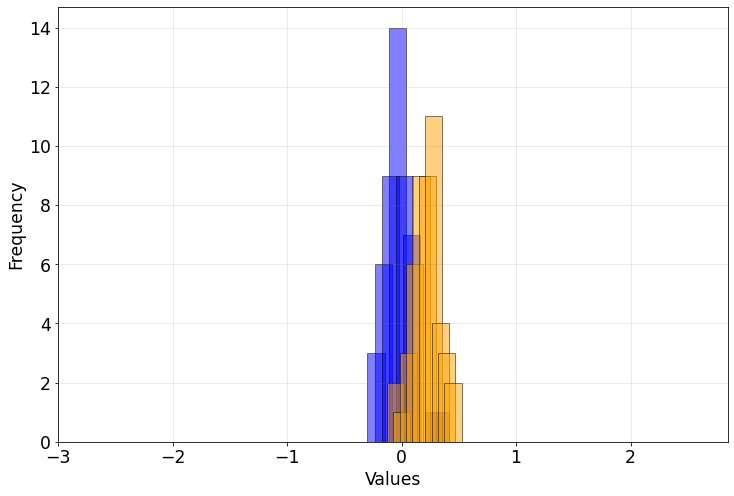

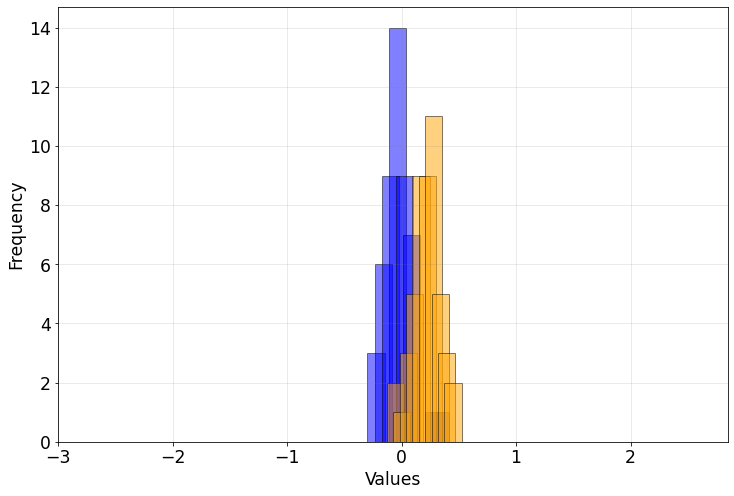

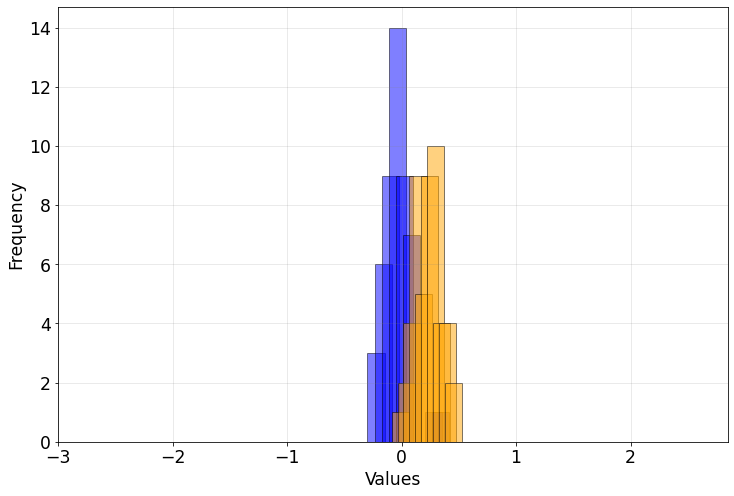

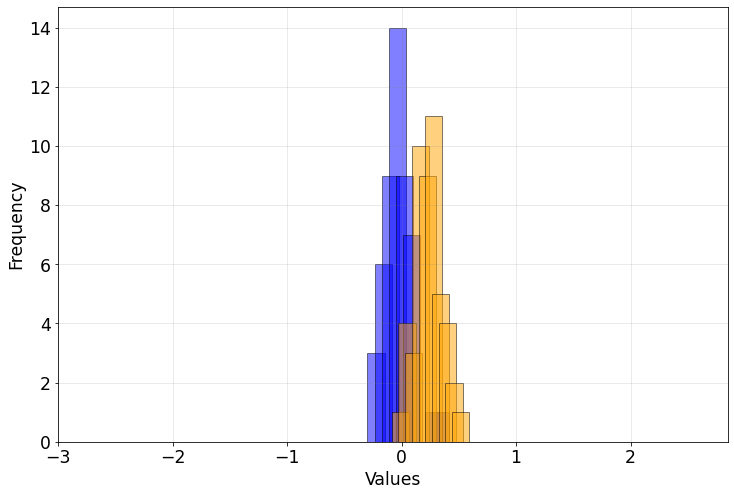

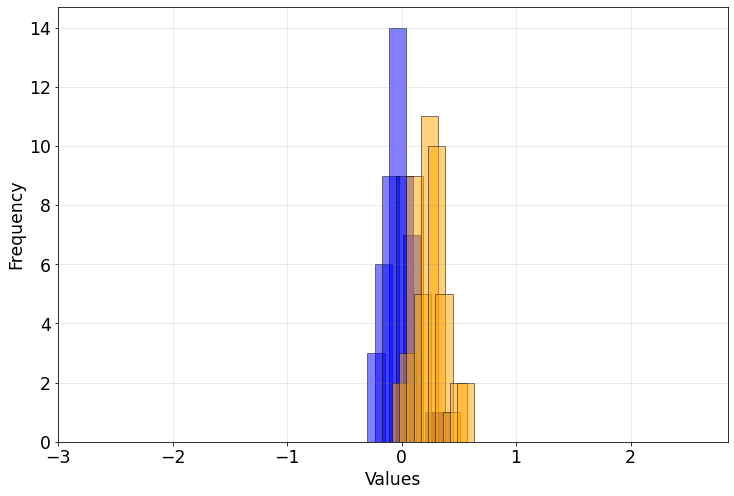

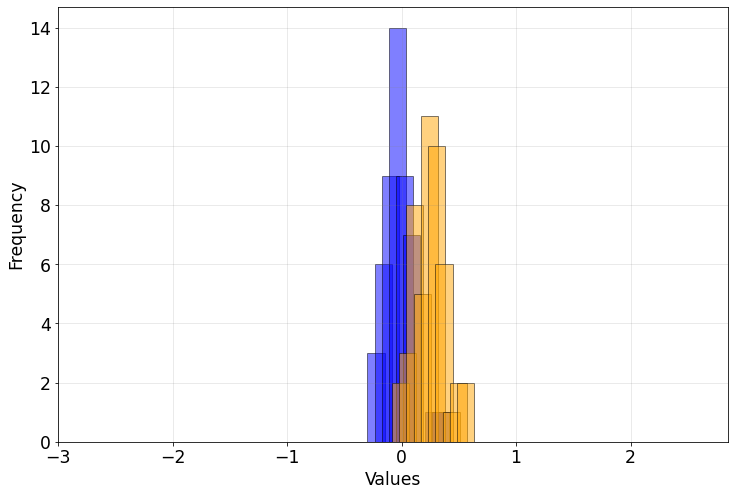

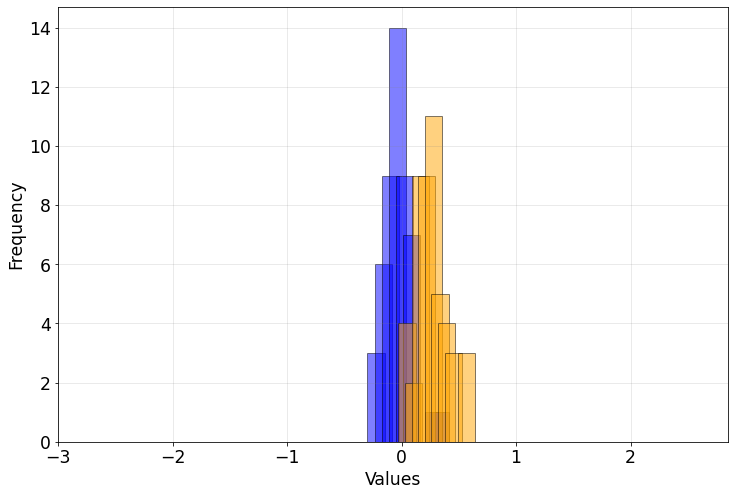

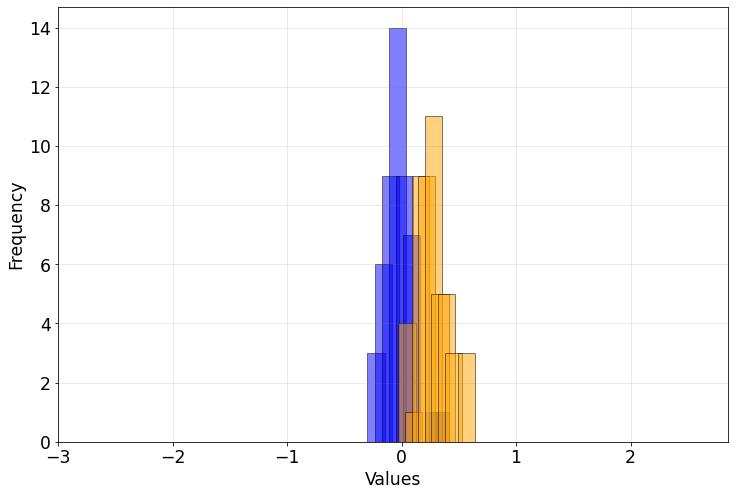

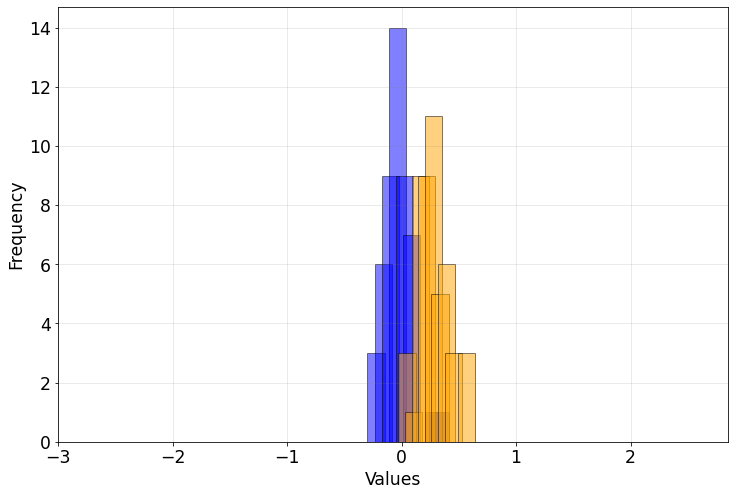

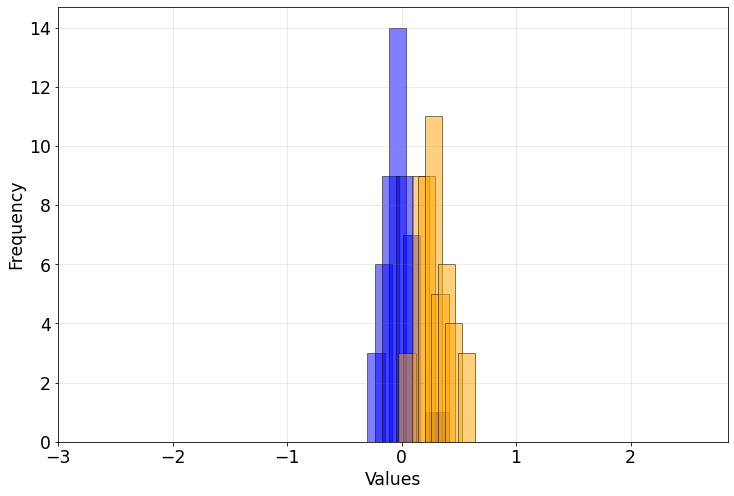

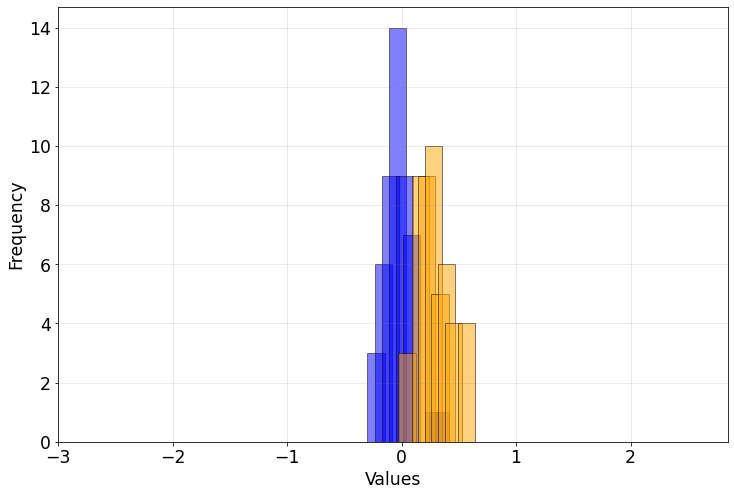

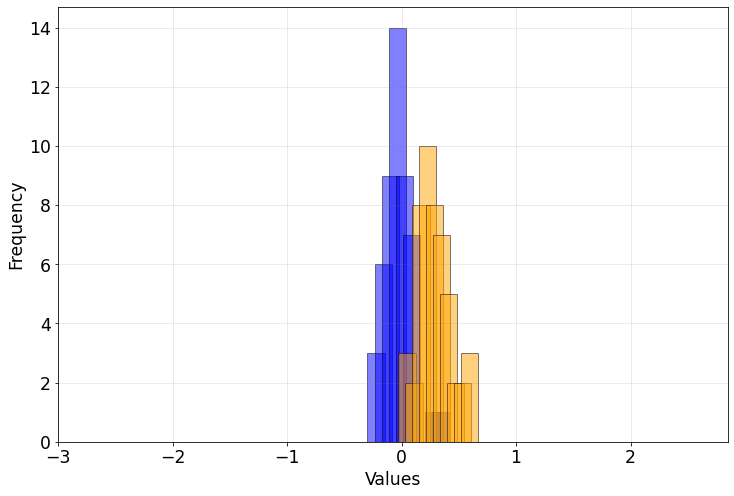

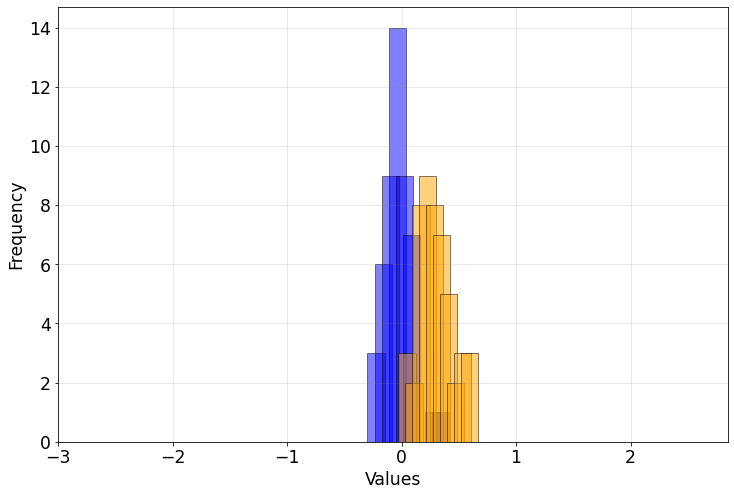

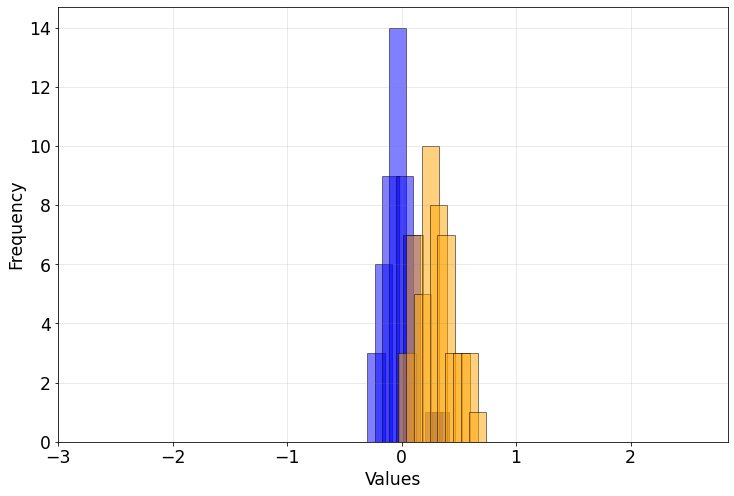

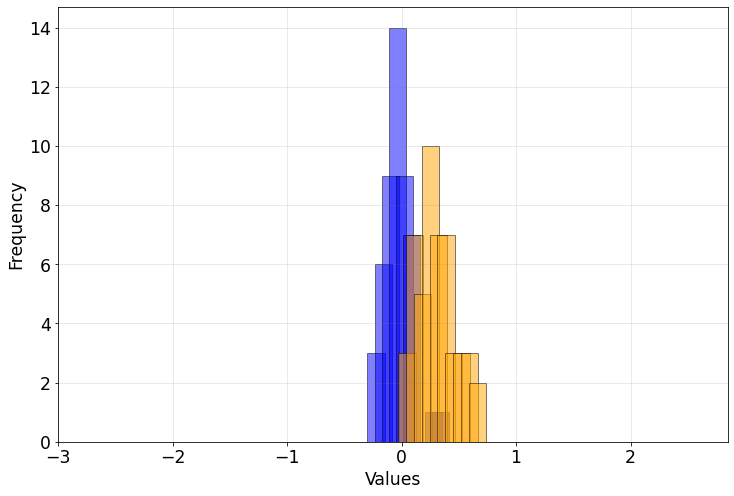

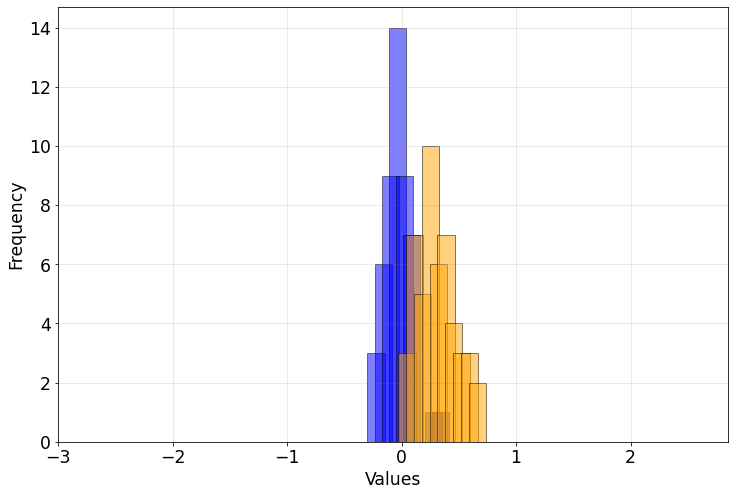

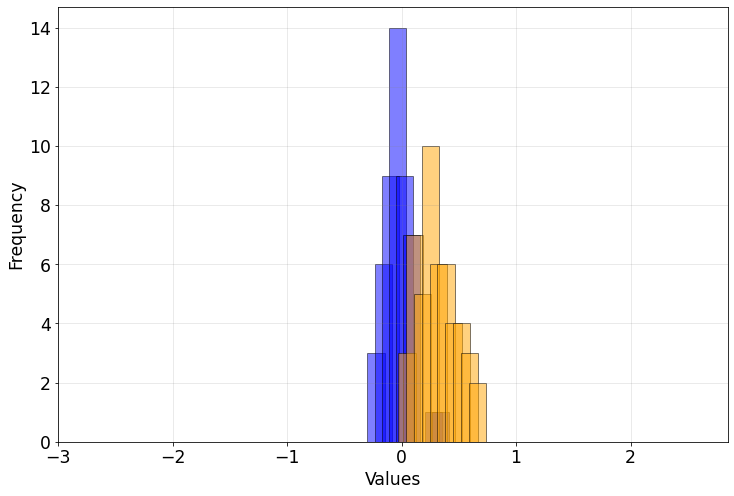

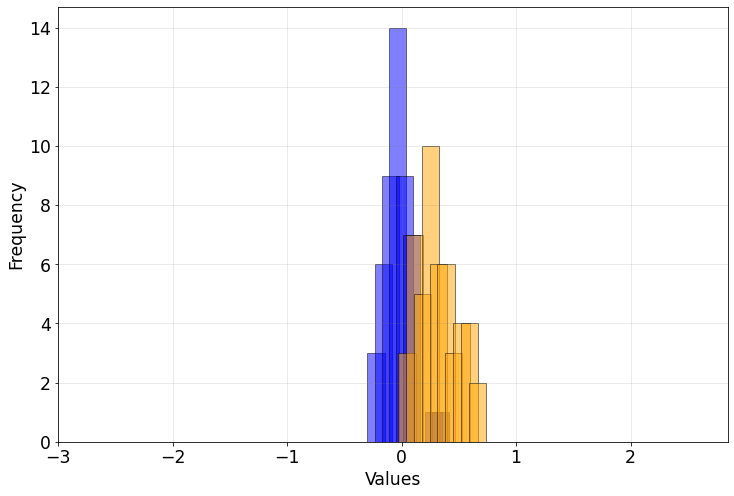

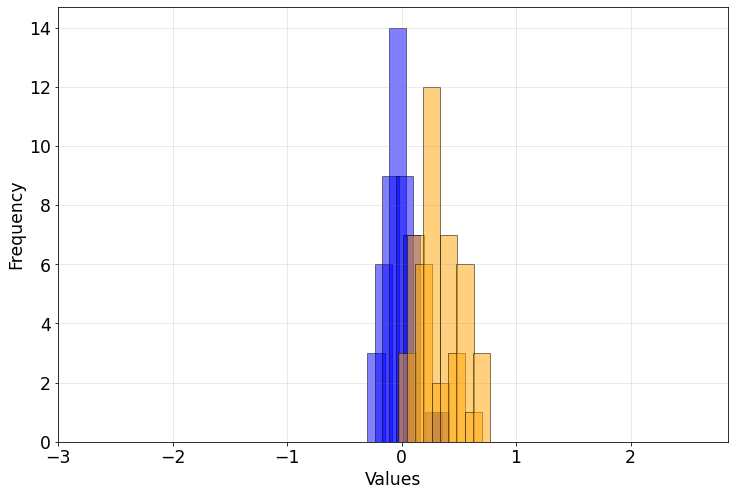

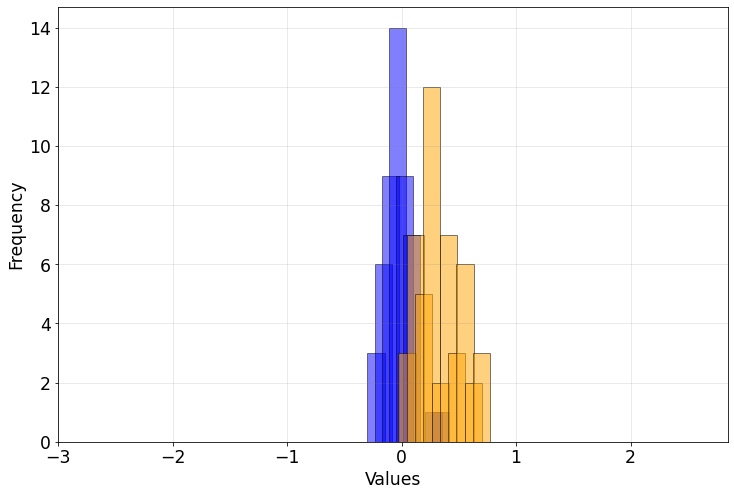

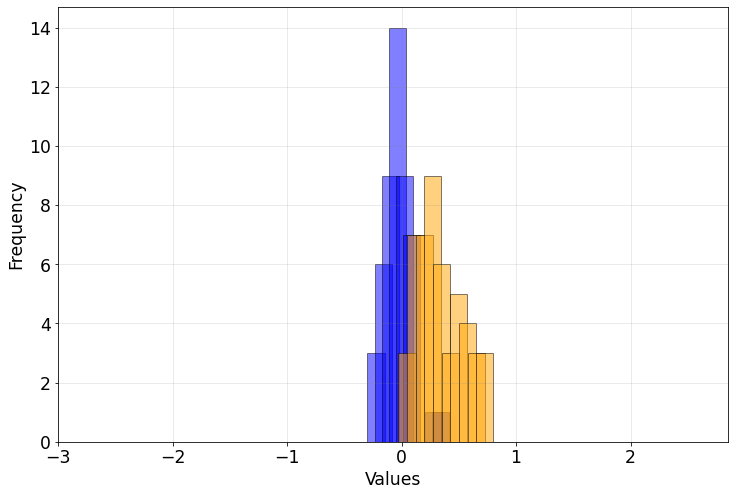

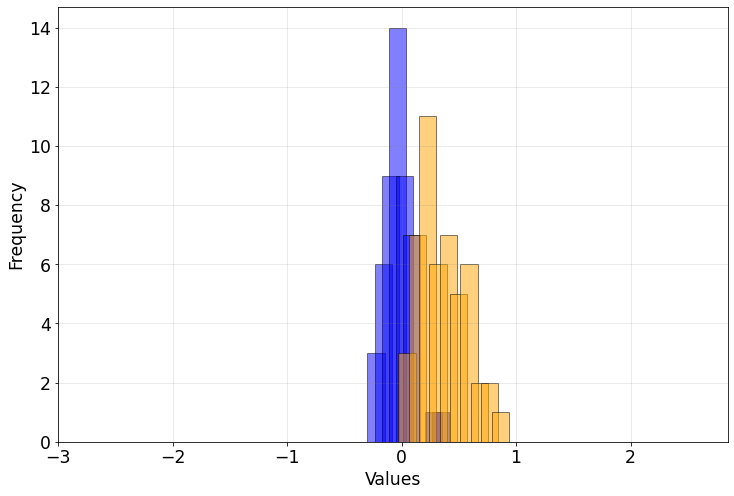

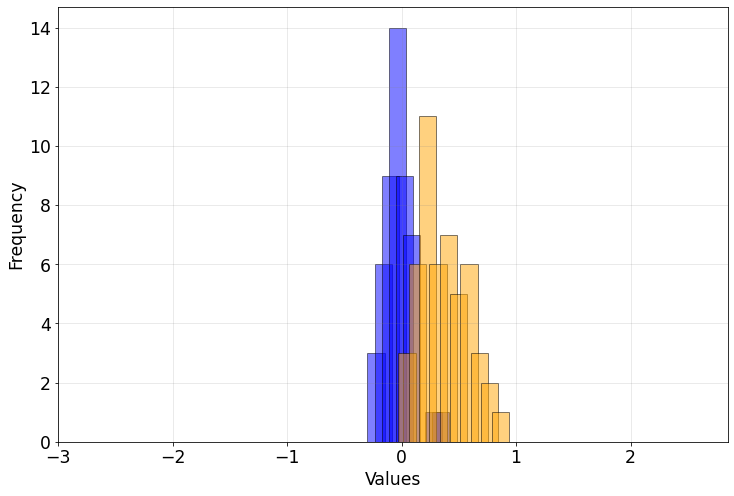

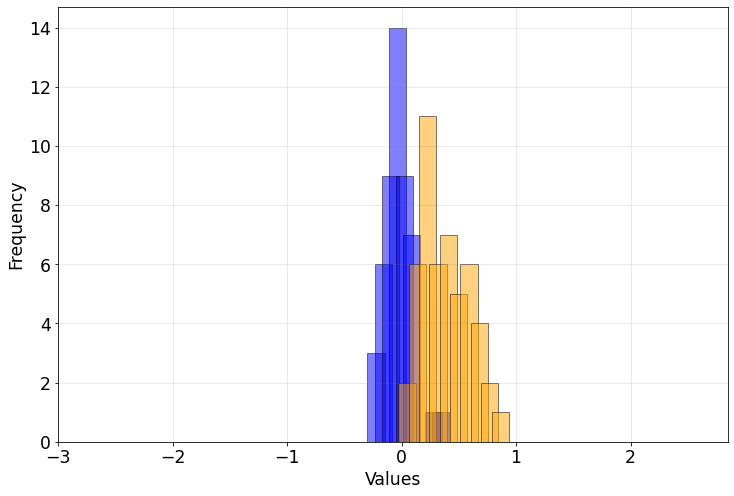

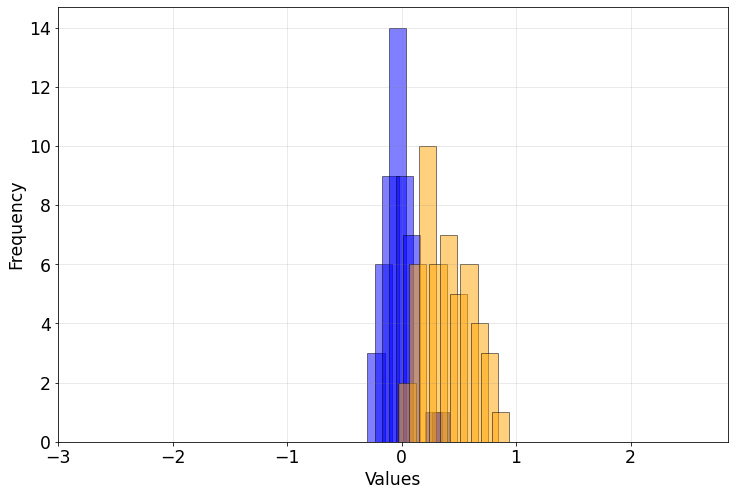

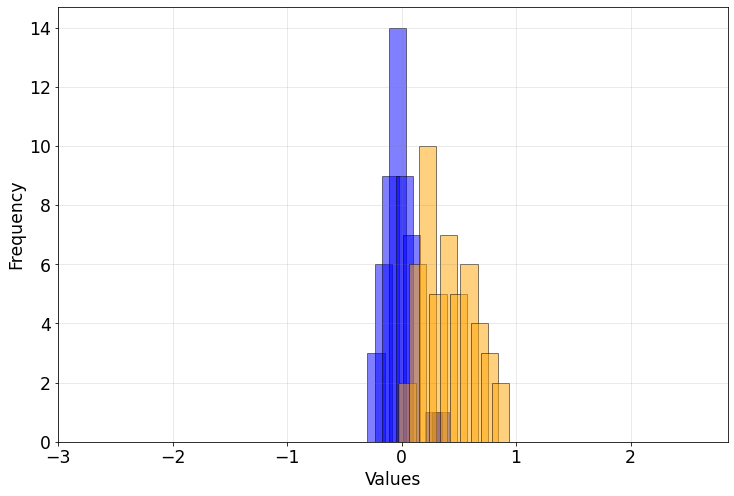

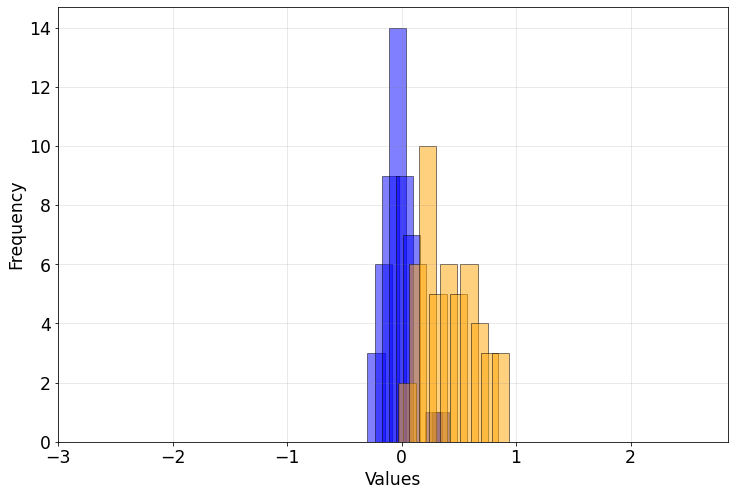

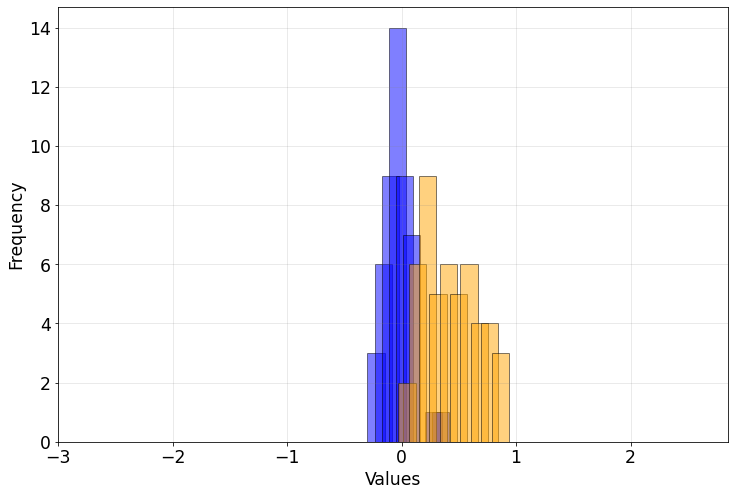

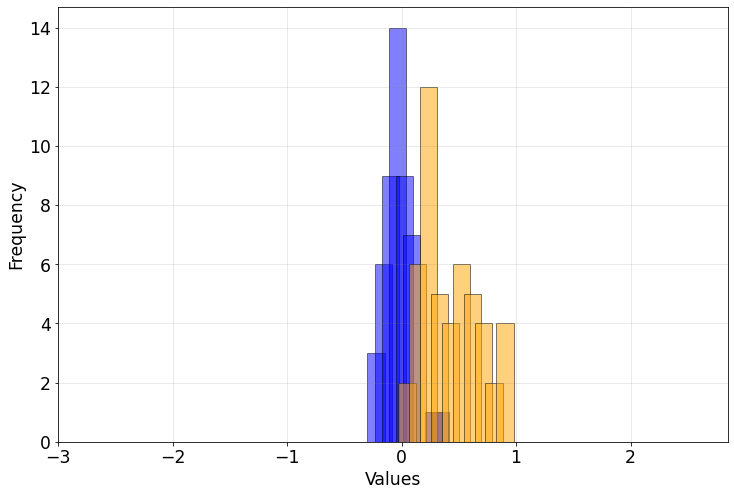

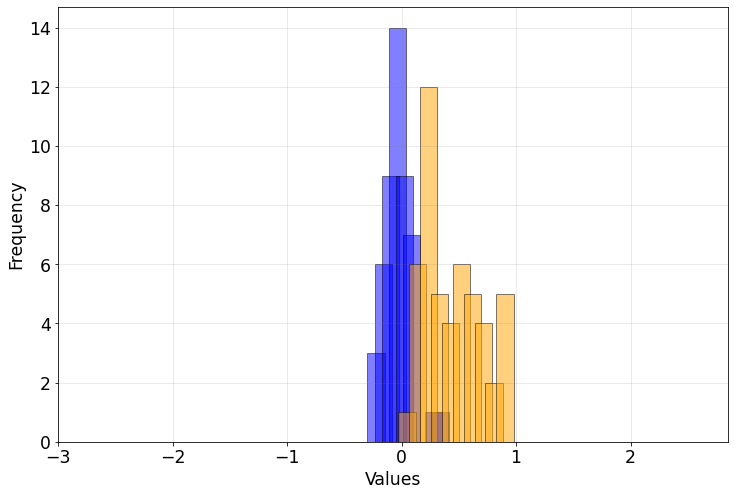

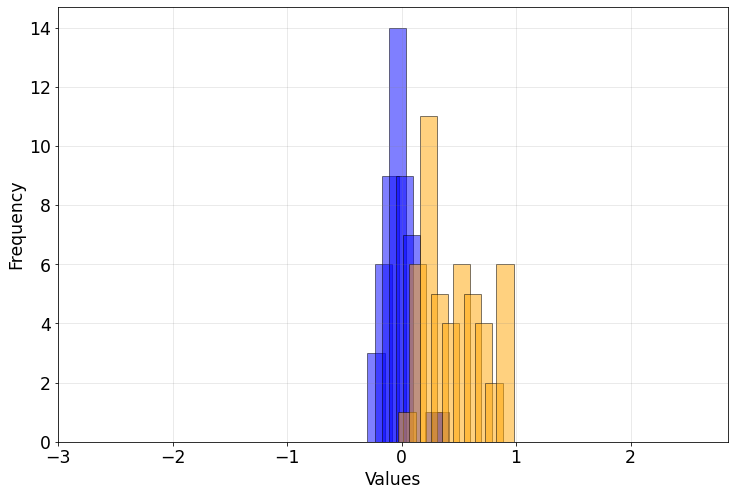

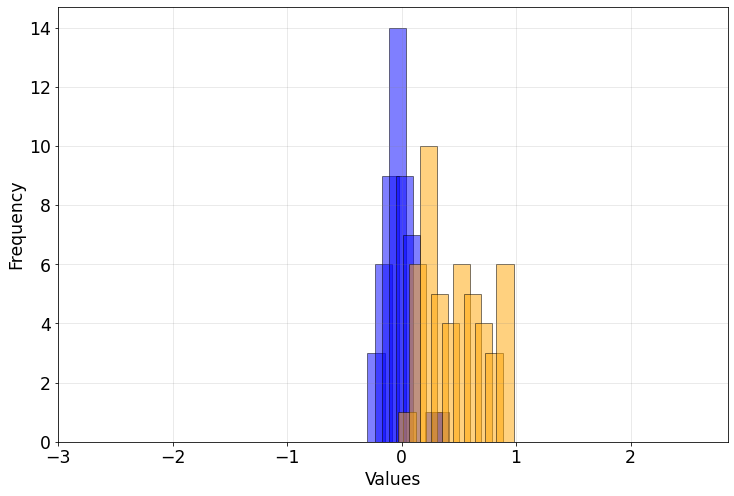

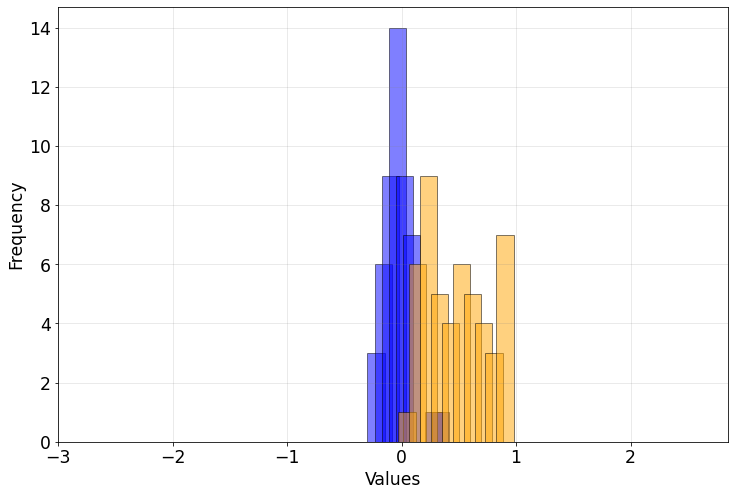

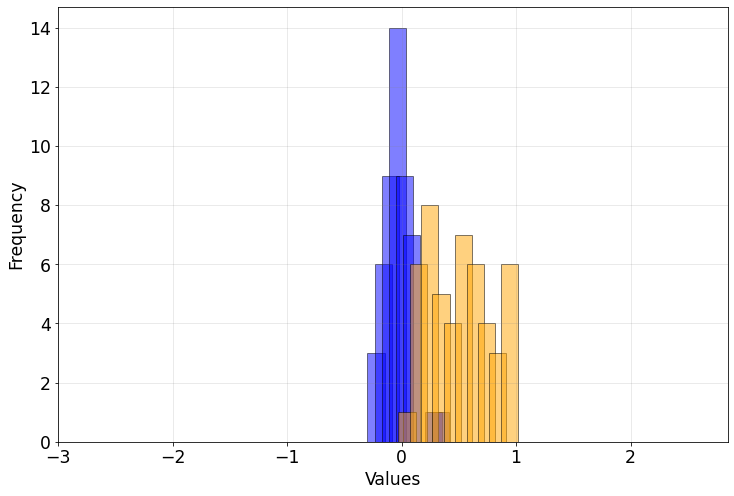

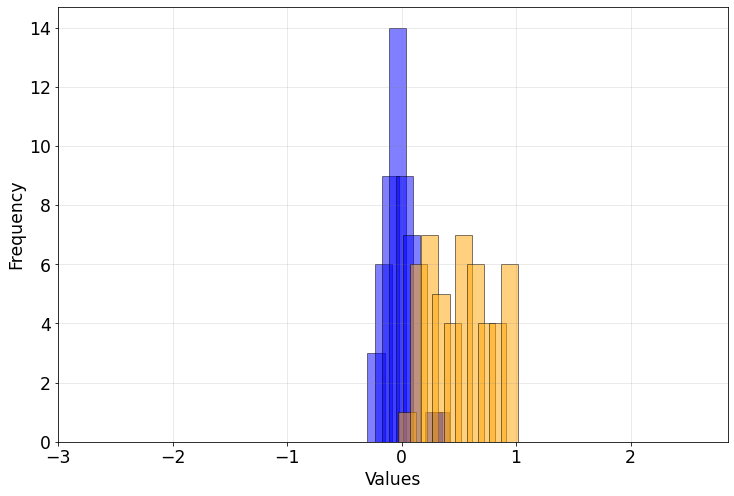

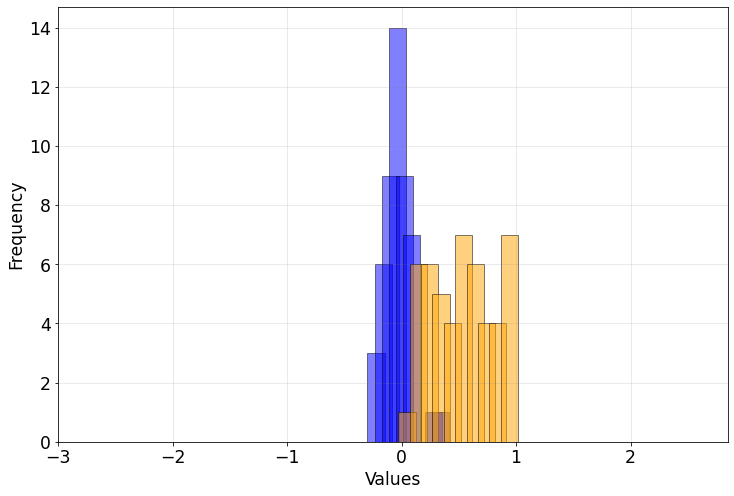

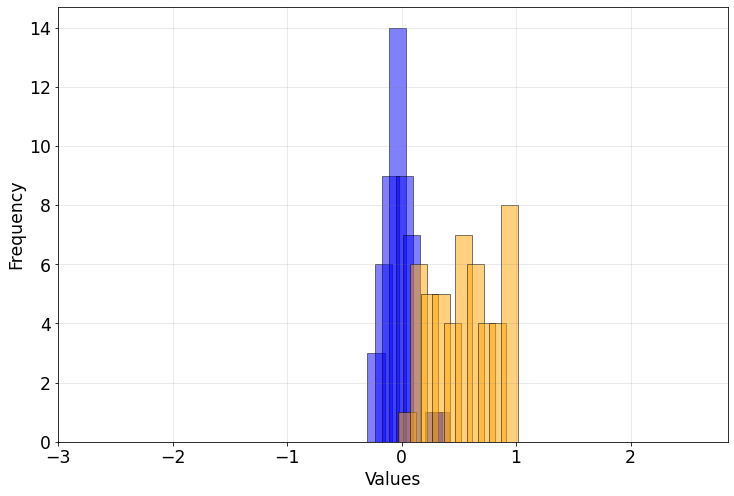

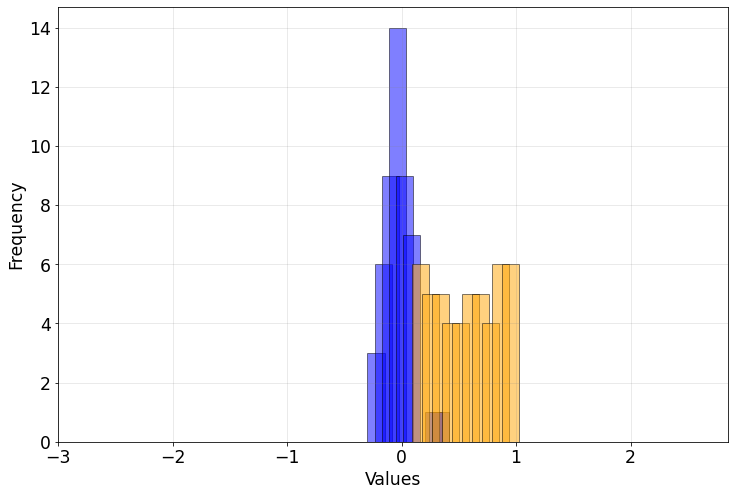

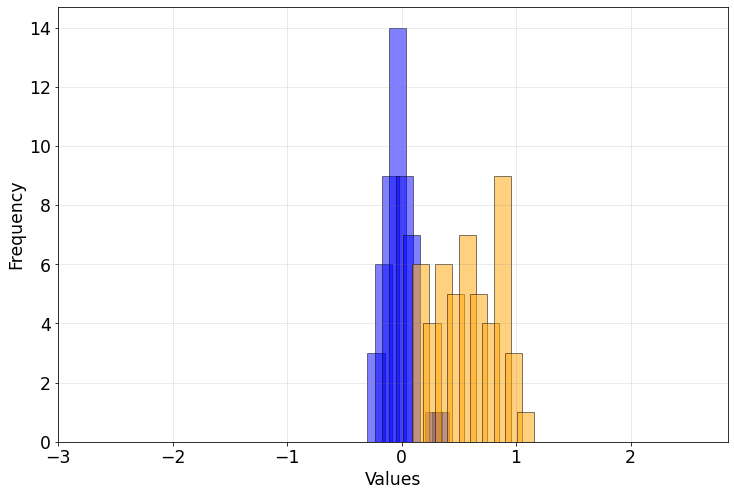

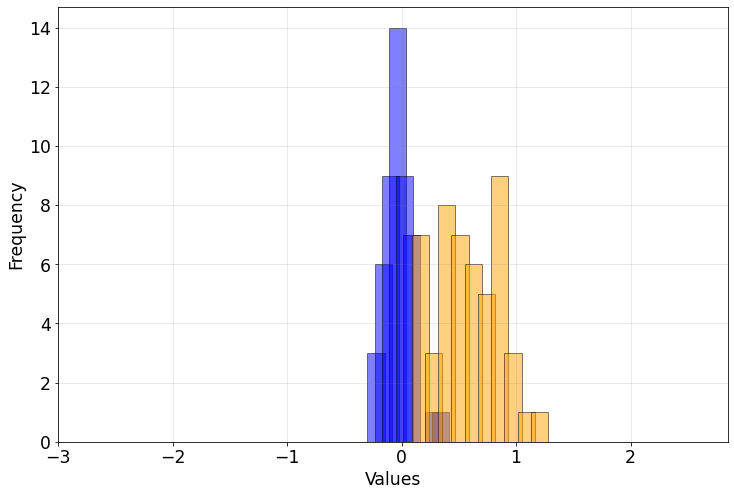

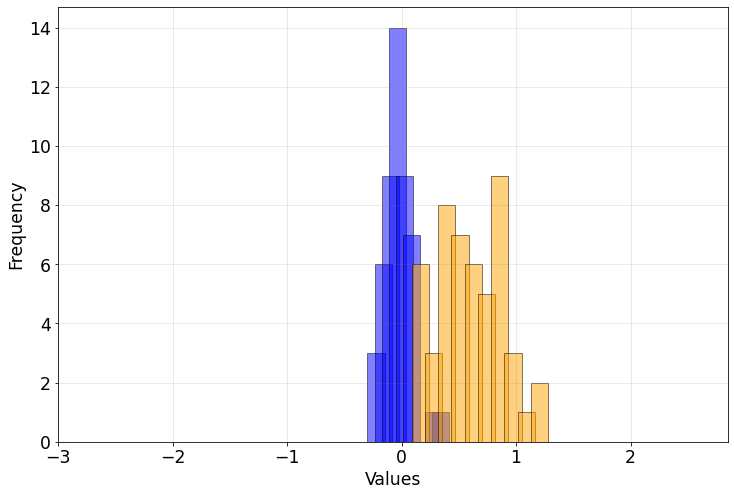

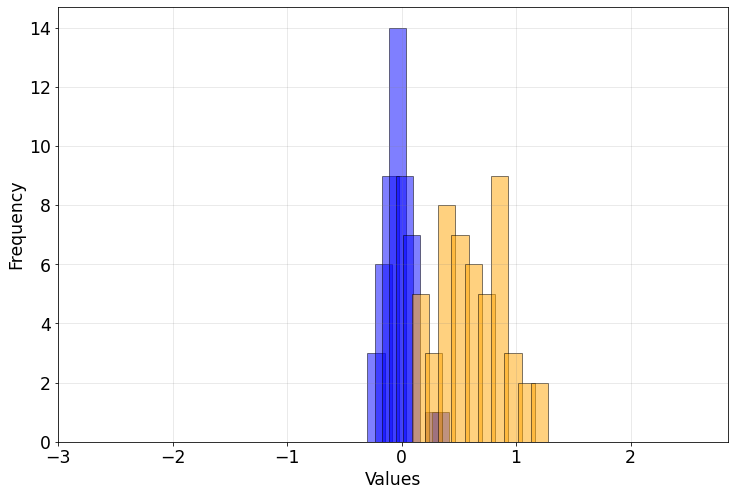

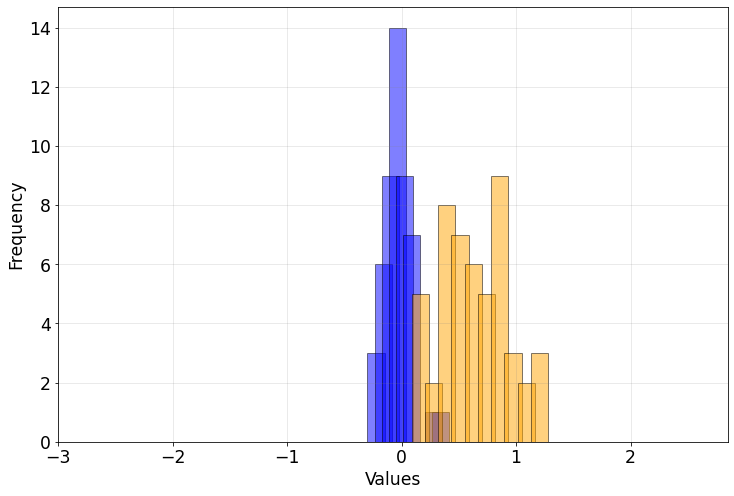

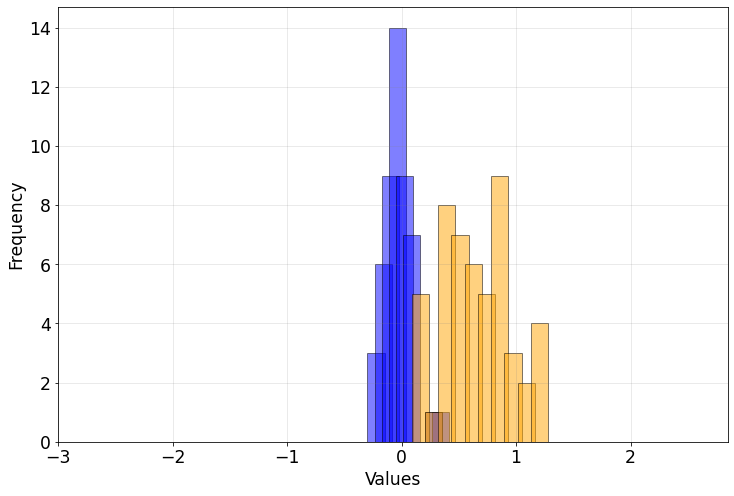

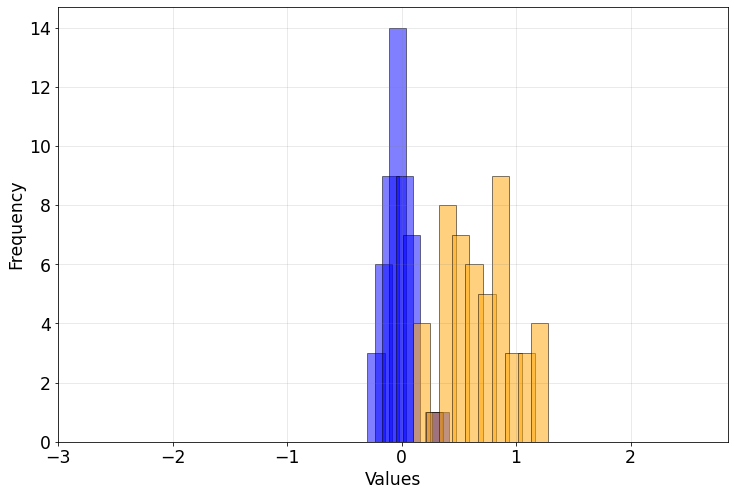

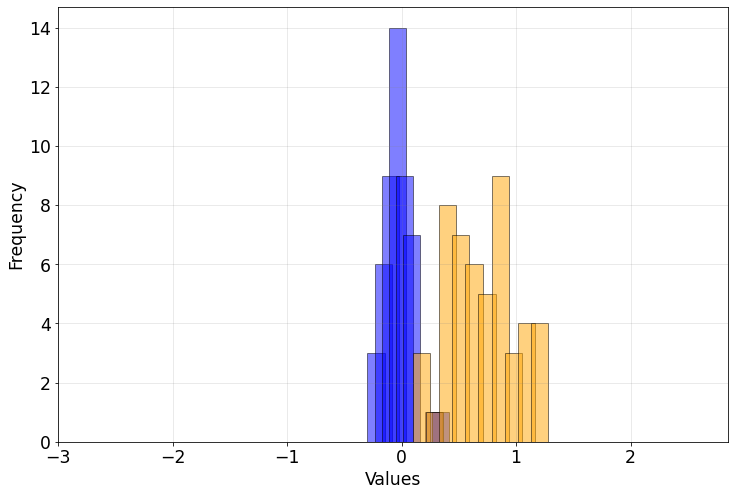

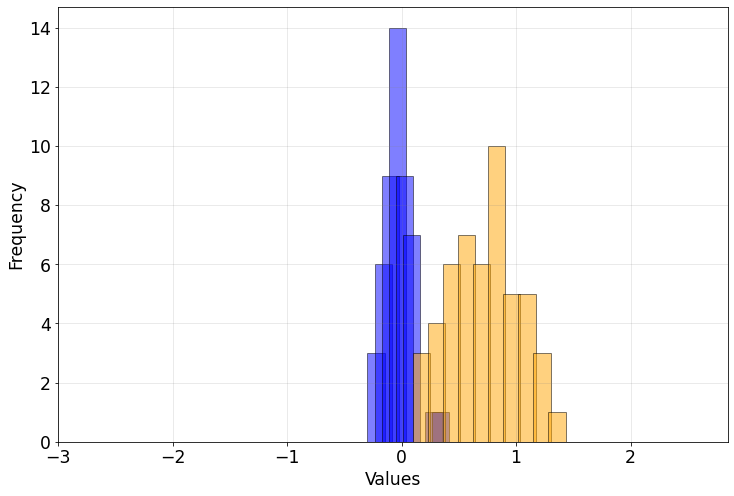

In [86]:
for i in range(0, len(best_ds_smean)-50):
    print(f'{i}, ', end='')
    fig , ax = plt.subplots(figsize=(12, 8))

    hist_b, bin_edges_b = np.histogram(best_ds_smean.isel(time=slice(0, 50)).values)
    #ax.hist(bin_edges_b[:-1], bin_edges_b, weights=hist_b, edgecolor='black', color='orange')
    plt.bar(bin_edges_b[:-1], hist_b,width=0.15, edgecolor='black', color='blue', alpha=0.5)

    
    hist, bin_edges = np.histogram(best_ds_smean.isel(time=slice(i, i+50)).values)
    plt.bar(bin_edges[:-1], hist,width=0.15, edgecolor='black', color='orange', alpha=0.5)
    #ax.hist(bin_edges[:-1], bin_edges, weights=hist, edgecolor='black', color='blue', alpha=0.5)
    
    # Add title and labels
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.set_xlim(np.take(bins, [0, -1]))
    ax.grid(True, alpha=0.2, color='grey')

In [107]:
step = 0.1

In [118]:
bins = np.arange(-3, 3+step, step)

<BarContainer object of 60 artists>

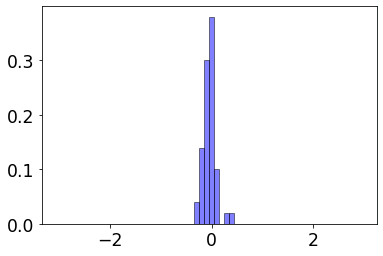

In [132]:
hist_b, bin_edges_b = np.histogram(best_ds_smean.isel(time=slice(0, 50)).values, bins=bins)
hist_b = hist_b/np.nansum(hist_b)

#ax.hist(bin_edges_b[:-1], bin_edges_b, weights=hist_b, edgecolor='black', color='orange')
plt.bar(bins[:-1], hist_b,width=step, edgecolor='black', color='blue', alpha=0.5)

<BarContainer object of 60 artists>

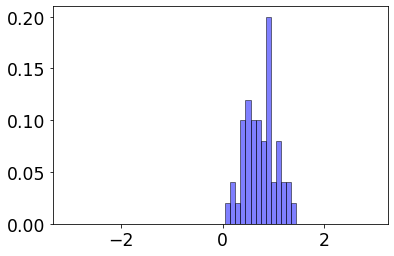

In [133]:
hist, bin_edges = np.histogram(best_ds_smean.isel(time=slice(i, i+50)).values, bins=bins)
hist = hist/np.nansum(hist)
plt.bar(bins[:-1], hist,width=step, edgecolor='black', color='blue', alpha=0.5)# weights=hist, edgecolor='black', color='blue', alpha=0.5)

<BarContainer object of 60 artists>

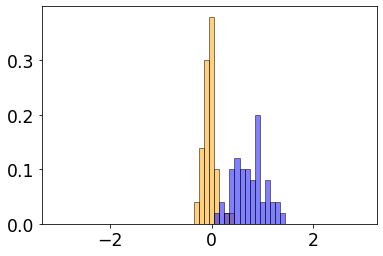

In [136]:
plt.bar(bins[:-1], hist_b,width=step, edgecolor='black', color='orange', alpha=0.5)
plt.bar(bins[:-1], hist,width=step, edgecolor='black', color='blue', alpha=0.5)

In [139]:
GIF_DIR = '/g/data/w40/ab2313/gifs/toe_dists/v1'

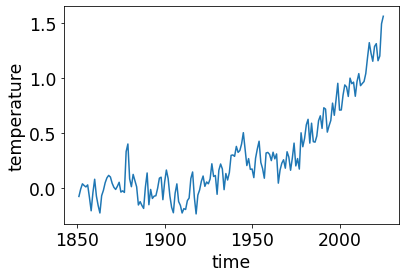

In [173]:
best_ds_smean.plot()

In [180]:
# step = 0.1
step = 0.05

In [181]:
bins = np.arange(-1.5, 1.5+step, step)

In [185]:
for i in range(0, len(best_ds_smean)-50):
    print(f'{i}, ', end='')
    fig , ax = plt.subplots(figsize=(12, 8))

    hist_b, bin_edges_b = np.histogram(best_ds_smean.isel(time=slice(0, 50)).values, bins=bins)
    hist_b = hist_b/np.nansum(hist_b)

    selection = best_ds_smean.isel(time=slice(i, i+50))
    hist, bin_edges = np.histogram(selection.values, bins=bins)
    hist = hist/np.nansum(hist)
    
    ax.bar(bins[:-1], hist_b, width=step, edgecolor='black', color='blue', alpha=0.5)
    ax.bar(bins[:-1], hist, width=step, edgecolor='black', color='orange', alpha=0.5)

    
    # Add title and labels
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.set_ylim(0, 0.3)
    ax.set_xlim(np.take(bins, [0, -1]))
    ax.grid(True, alpha=0.2, color='grey')
    years = selection.time.dt.year.values
    start_year = years[0]
    end_year = years[-1]
    ax.set_title(f'{start_year} - {end_year}', fontsize=16)

    fname = "{:03d}".format(i) + '.png'
    plt.savefig(os.path.join(GIF_DIR, fname))
    plt.close(fig)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 

In [186]:
from PIL import Image
import glob
 
def save_gif(image_filenames,gif_filename):
  frames = []
  imgs = sorted(glob.glob(image_filenames))
  for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
  
  frames[0].save(gif_filename, format='GIF',
    append_images=frames[1:],
    save_all=True,
    duration=0.0001, loop=5)


In [188]:
GIF_SAVE_DIR = '/g/data/w40/ab2313/gifs/toe_dists'
gif_filename = "toe_2.gif"
save_gif(GIF_DIR + "/*.png",os.path.join(GIF_SAVE_DIR, gif_filename))
print('Created ' + gif_filename)

Created toe_2.gif


In [224]:
import stats

In [226]:
best_ds_poly = stats.trend_fit(best_ds,method='polynomial', order=5)

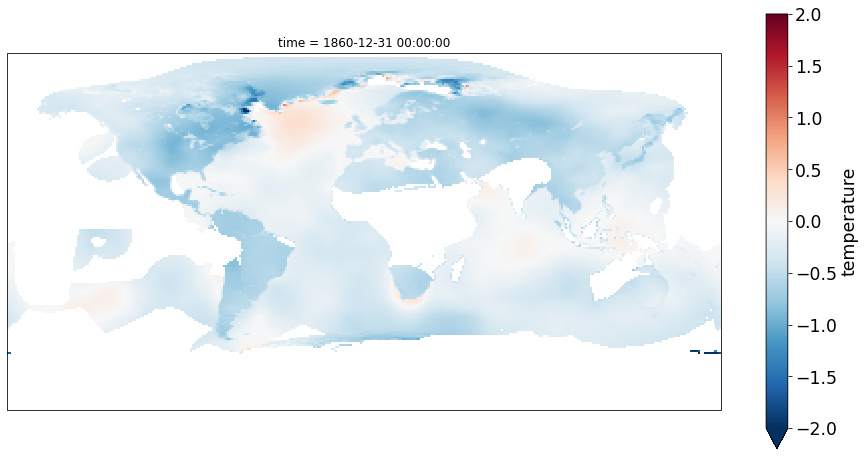

In [228]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
best_ds_poly.isel(time=10).plot(vmin=-2, vmax=2, cmap='RdBu_r')

In [221]:
SAVE_PNG_DIR = '/g/data/w40/ab2313/gifs/best_time_series/pngs_2'

In [229]:
for num,time in enumerate(best_ds.time.values[::4]):
    print(f'{num},', end='')
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    best_ds_poly.sel(time=time).plot(levels=np.arange(-2.5,2.6, 0.1), cmap='RdBu_r', extend='both')
    ax.set_title(time.year, fontsize=22)
    fname = "{:03d}".format(num) + '.png'
    fig.savefig(os.path.join(SAVE_PNG_DIR, fname))
    plt.close(fig)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,

In [230]:
BEST_GIF_SAVE_DIR = '/g/data/w40/ab2313/gifs/best_time_series'
gif_filename = "best_poly_v1.gif"
save_gif(SAVE_PNG_DIR + "/*.png", os.path.join(BEST_GIF_SAVE_DIR, gif_filename))
print('Created ' + gif_filename)

Created best_poly_v1.gif
